In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures



In [2]:
df = pd.read_csv('mainset2.csv')
print('SHAPE : ', df.shape) 
df.columns

SHAPE :  (514704, 46)


Index(['date', 'season_id', 'location', 'type', 'outcome', 'difference',
       'game_id', 'team_id', 'team_abb', 'team_city', 'player_id', 'name',
       'start_position', 'age_days', 'height', 'seconds', 'fgm', 'fga', 'fg3m',
       'fg3a', 'ftm', 'fta', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'to',
       'pf', 'pts', 'poss', 'off_rate', 'def_rate', 'net_rate', 'pace',
       'ast_pct', 'ast_tov', 'ast_ratio', 'oreb_pct', 'dreb_pct', 'reb_pct',
       'tm_tov_pct', 'usg_pct', 'game_score', 'plus_minus'],
      dtype='object')

In [3]:
# Display by pts per 40 mins
X = df.groupby(['player_id','name']).mean()
# Create games_played column
X['games_played'] = df.groupby(['player_id','name']).size()
# FG percent
X['fgpct'] = (X['fgm'] / (X['fga'] + .000001))
# FG 3 percent
X['fg3pct'] = (X['fg3m'] / (X['fg3a'] + .000001))
#  FT percent
X['ftpct'] = (X['ftm'] / (X['fta'] + .000001))
# John Hollinger Game Score per 40 mins
X['gs'] = X['pts'] + .4*X['fgm'] - .7*X['fga'] - .4*(X['fta'] - X['ftm']) + .7*X['oreb'] + \
.3*X['dreb'] + X['stl'] + .7*X['ast'] + .7*X['blk'] - .4*X['pf'] - X['to']

X.drop(columns=['fgm','ftm','fg3m'],inplace=True)
X.columns
X[[col for col in X.loc[:,'seconds':'poss']]+['fgpct',
                                              'fg3pct',
                                              'ftpct',
                                              'games_played']].sort_values(by='pts', ascending=False).head(20)

,,seconds,fga,fg3a,fta,oreb,dreb,reb,ast,stl,blk,to,pf,pts,poss,fgpct,fg3pct,ftpct,games_played
player_id,name,,,,,,,,,,,,,,,,,,
947,Allen Iverson,2505.600519,22.766537,3.643320,9.298314,0.675746,2.937743,3.613489,6.121920,2.158236,0.155642,3.511025,1.783398,27.712062,82.367056,0.421808,0.313991,0.791742,771
2544,LeBron James,2335.645246,19.782951,4.385574,8.146230,1.247869,6.459016,7.706885,7.355410,1.613115,0.791475,3.523934,1.923934,27.365246,75.792787,0.502237,0.342255,0.735652,1525
201142,Kevin Durant,2243.145897,18.976697,5.050659,7.779129,0.740628,6.415400,7.156028,4.096251,1.101317,1.118541,3.130699,1.987842,27.338399,76.032421,0.489963,0.375928,0.879786,987
977,Kobe Bryant,2314.626587,21.176251,4.422704,7.940254,1.143391,4.423450,5.566841,5.088125,1.522031,0.489171,3.122479,2.618372,27.085885,75.909634,0.448281,0.329956,0.836343,1339
1629029,Luka Doncic,1990.384058,18.608696,7.956522,8.036232,1.217391,7.434783,8.652174,7.384058,1.057971,0.304348,3.891304,2.224638,25.137681,70.108696,0.448209,0.323315,0.732191,138
201935,James Harden,2067.162331,16.697190,7.652445,8.701353,0.777315,4.567118,5.344433,6.240375,1.599376,0.530697,3.664932,2.712799,24.943809,70.300728,0.440795,0.359124,0.859125,961
203076,Anthony Davis,2092.553571,17.451786,1.567857,7.210714,2.567857,7.878571,10.446429,2.280357,1.391071,2.369643,1.983929,2.428571,24.382143,71.285714,0.517855,0.321184,0.804854,560
203081,Damian Lillard,2201.937313,18.347761,7.798507,6.101493,0.629851,3.582090,4.211940,6.459701,0.998507,0.310448,2.816418,2.028358,24.253731,74.911940,0.434394,0.371292,0.887965,670
201939,Stephen Curry,2096.141089,17.456683,8.551980,4.233911,0.719059,3.936881,4.655941,6.590347,1.715347,0.228960,3.179455,2.491337,23.991337,73.292079,0.472244,0.429088,0.905583,808


In [44]:
X.loc[:,'seconds':].columns

Index(['seconds', 'fga', 'fg3a', 'fta', 'oreb', 'dreb', 'reb', 'ast', 'stl',
       'blk', 'to', 'pf', 'pts', 'poss', 'off_rate', 'def_rate', 'net_rate',
       'pace', 'ast_pct', 'ast_tov', 'ast_ratio', 'oreb_pct', 'dreb_pct',
       'reb_pct', 'tm_tov_pct', 'usg_pct', 'game_score', 'plus_minus',
       'games_played', 'fgpct', 'fg3pct', 'ftpct', 'gs'],
      dtype='object')

In [142]:
import pickle
with open('position_dict.pickle', 'rb') as f:
    position_dict = pickle.load(f)
    
# X['target'] = X.index.map(lambda x: position_dict[x[0]])

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                     stratify=y, test_size=0.2, random_state=1)

# poly = PolynomialFeatures()
# poly.fit(X_train)
# X_train = pd.DataFrame(poly.transform(X_train),
#                        columns=poly.get_feature_names([c for c in X_train if c!=0]))
# X_test = pd.DataFrame(poly.transform(X_test),
#                        columns=poly.get_feature_names([c for c in X_train if c!=0]))

# power = PowerTransformer()
# X_train = pd.DataFrame(power.fit_transform(X_train),
#                        columns=X_train.columns)
# X_test = pd.DataFrame(power.transform(X_test),
#                       columns=X_train.columns)

In [47]:
X[[col for col in X.loc[:,'seconds':] if col not in ['games_played']].copy().fillna(0, inplace=True)]

SyntaxError: unexpected EOF while parsing (<ipython-input-47-b543c28562ce>, line 1)

In [54]:
X[[col for col in X.loc[:,'seconds':] if col not in ['games_played']]]


,,seconds,fga,fg3a,fta,oreb,dreb,reb,ast,stl,blk,...,dreb_pct,reb_pct,tm_tov_pct,usg_pct,game_score,plus_minus,fgpct,fg3pct,ftpct,gs
player_id,name,,,,,,,,,,,,,,,,,,,,,
3,Grant Long,1398.607843,4.583333,0.191176,1.823529,1.073529,2.955882,4.029412,1.392157,0.911765,0.181373,...,0.146678,0.096099,14.489216,0.124010,4.337745,-3.504902,0.429946,0.179486,0.725806,4.339216
15,Eric Piatkowski,1240.447307,6.346604,3.063232,1.407494,0.571429,1.765808,2.337237,1.077283,0.508197,0.145199,...,0.112012,0.065381,9.753864,0.162972,5.459953,-1.105386,0.432103,0.405963,0.855241,5.459953
21,Greg Anthony,1173.976303,5.672986,2.781991,1.222749,0.289100,1.322275,1.611374,2.819905,0.895735,0.099526,...,0.096276,0.053994,12.278199,0.168100,4.861137,-0.018957,0.390977,0.361158,0.717054,4.870616
22,Rik Smits,1374.128713,10.861386,0.019802,2.485149,1.168317,3.574257,4.742574,1.049505,0.297030,1.188119,...,0.163883,0.106173,9.445545,0.263723,7.837624,-0.485149,0.486782,0.000000,0.760956,7.837624
23,Dennis Rodman,1940.833333,2.583333,0.083333,1.166667,4.000000,10.250000,14.250000,1.166667,0.166667,0.083333,...,0.329250,0.213250,33.758333,0.059583,5.258333,-6.333333,0.387097,0.000000,0.714285,5.258333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629744,Matt Thomas,807.750000,4.500000,2.916667,0.277778,0.250000,1.638889,1.888889,0.750000,0.305556,0.055556,...,0.132871,0.073656,7.338889,0.145917,4.686111,3.777778,0.518518,0.476190,0.799997,4.686111
1629745,Tariq Owens,423.000000,4.000000,1.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,NaN,0.133000,0.000000,0.235000,1.000000,-12.000000,0.250000,0.000000,0.000000,1.000000
1629750,Javonte Green,759.294118,3.588235,1.029412,1.058824,0.676471,1.705882,2.382353,0.735294,0.676471,0.176471,...,0.165000,0.108138,9.782353,0.142265,3.882353,0.058824,0.491803,0.285714,0.694444,3.882353


In [61]:
X_train.fillna(0)

,,seconds,fga,fg3a,fta,oreb,dreb,reb,ast,stl,blk,...,dreb_pct,reb_pct,tm_tov_pct,usg_pct,game_score,plus_minus,fgpct,fg3pct,ftpct,gs
player_id,name,,,,,,,,,,,,,,,,,,,,,
3,Grant Long,1398.607843,4.583333,0.191176,1.823529,1.073529,2.955882,4.029412,1.392157,0.911765,0.181373,...,0.146678,0.096099,14.489216,0.124010,4.337745,-3.504902,0.429946,0.179486,0.725806,4.339216
15,Eric Piatkowski,1240.447307,6.346604,3.063232,1.407494,0.571429,1.765808,2.337237,1.077283,0.508197,0.145199,...,0.112012,0.065381,9.753864,0.162972,5.459953,-1.105386,0.432103,0.405963,0.855241,5.459953
21,Greg Anthony,1173.976303,5.672986,2.781991,1.222749,0.289100,1.322275,1.611374,2.819905,0.895735,0.099526,...,0.096276,0.053994,12.278199,0.168100,4.861137,-0.018957,0.390977,0.361158,0.717054,4.870616
22,Rik Smits,1374.128713,10.861386,0.019802,2.485149,1.168317,3.574257,4.742574,1.049505,0.297030,1.188119,...,0.163883,0.106173,9.445545,0.263723,7.837624,-0.485149,0.486782,0.000000,0.760956,7.837624
23,Dennis Rodman,1940.833333,2.583333,0.083333,1.166667,4.000000,10.250000,14.250000,1.166667,0.166667,0.083333,...,0.329250,0.213250,33.758333,0.059583,5.258333,-6.333333,0.387097,0.000000,0.714285,5.258333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629744,Matt Thomas,807.750000,4.500000,2.916667,0.277778,0.250000,1.638889,1.888889,0.750000,0.305556,0.055556,...,0.132871,0.073656,7.338889,0.145917,4.686111,3.777778,0.518518,0.476190,0.799997,4.686111
1629745,Tariq Owens,423.000000,4.000000,1.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.133000,0.000000,0.235000,1.000000,-12.000000,0.250000,0.000000,0.000000,1.000000
1629750,Javonte Green,759.294118,3.588235,1.029412,1.058824,0.676471,1.705882,2.382353,0.735294,0.676471,0.176471,...,0.165000,0.108138,9.782353,0.142265,3.882353,0.058824,0.491803,0.285714,0.694444,3.882353


In [62]:
X_train = X[[col for col in X.loc[:,'seconds':] if col not in ['games_played']]].copy()
X_train.fillna(0, inplace=True)

no_polynomials = [col for col in X_train.loc[:,'seconds':] if X_train[col].min()<0]
polynomials = [col for col in X_train.loc[:,'seconds':] if col not in no_polynomials]

In [156]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

poly_x = X_train[polynomials].copy()
non_poly_x = X_train[no_polynomials].copy()

poly = PolynomialFeatures()

poly_x = pd.DataFrame(poly.fit_transform(poly_x),
                      columns=poly.get_feature_names([c for c in ['1']+polynomials if c!=0]),
                      index=non_poly_x.index)

X_poly = pd.concat([poly_x,non_poly_x], join='outer',axis=1)
del poly_x
del non_poly_x

scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_poly),
                     columns=X_poly.columns,
                     index=X_poly.index)

pca = PCA()
X_pca = pd.DataFrame(pca.fit_transform(X_std),
                    columns=[f'PC_{c}' for c in range(1,len(X_std.columns)+1)],
                    index=X_std.index)
X_pca

,,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_430,PC_431,PC_432,PC_433,PC_434,PC_435,PC_436,PC_437,PC_438,PC_439
player_id,name,,,,,,,,,,,,,,,,,,,,,
3,Grant Long,-1.165134,2.602894,2.071308,-0.321961,-5.000467,1.945706,-1.231869,3.077123,3.673772,-1.230383,...,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,-0.000000e+00,3.733913e-14
15,Eric Piatkowski,-3.662888,-5.910060,-5.354332,2.393227,0.591682,1.927235,-1.105652,-0.299199,0.305792,-1.359896,...,1.192470e-15,6.338161e-16,-1.130116e-15,-6.111380e-16,-5.788057e-17,-3.766282e-16,-1.026498e-15,9.476758e-16,3.109653e-16,2.532597e-16
21,Greg Anthony,-1.889587,-11.146726,3.382740,1.247434,-1.758082,0.983100,-0.261471,-0.482470,0.823443,-0.698198,...,-2.373989e-15,-6.096400e-16,2.533352e-15,-2.193714e-16,-1.698395e-16,-2.256772e-16,-1.731932e-15,1.695163e-15,-4.302885e-16,-1.048516e-16
22,Rik Smits,7.278997,10.495509,-4.350612,-6.676168,-0.496942,0.078887,-4.380648,-6.094628,-4.780947,-1.502366,...,-8.437487e-16,-1.193027e-15,1.217850e-15,1.701505e-15,-1.491266e-15,1.843664e-15,7.394729e-16,1.155674e-15,-7.922604e-16,-4.940970e-16
23,Dennis Rodman,18.204213,37.305147,14.802525,6.701491,-9.076655,7.146874,14.215735,24.474243,2.185293,-11.830260,...,-4.507009e-16,-1.689304e-16,6.577847e-16,2.569827e-16,-4.097435e-16,2.612617e-17,4.990370e-17,7.615235e-18,5.975232e-16,-8.725937e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629744,Matt Thomas,-8.974091,-6.288073,-3.503960,6.026165,3.358946,0.023855,0.284326,-1.554180,-0.316618,1.356401,...,-3.830999e-16,6.128427e-16,6.653031e-16,4.691777e-16,8.705755e-16,-5.456405e-16,5.048976e-16,6.260006e-16,3.714069e-16,-9.463553e-19
1629745,Tariq Owens,-19.958936,2.737778,-11.032037,-8.002984,1.634682,-6.052474,-4.112624,2.455964,1.514217,2.006080,...,-4.756269e-16,1.323333e-16,-1.436613e-16,8.185737e-16,-2.734651e-16,1.670397e-16,3.183543e-16,4.485877e-16,-2.027009e-16,-1.961323e-17
1629750,Javonte Green,-8.433267,-0.166209,0.596389,3.932777,1.515537,-0.722903,-0.642667,0.613667,0.707804,2.957631,...,1.783568e-16,-6.038293e-16,6.982827e-17,-1.075719e-15,-5.420703e-16,1.525175e-16,4.917241e-17,-2.887797e-16,7.330862e-16,8.647880e-17


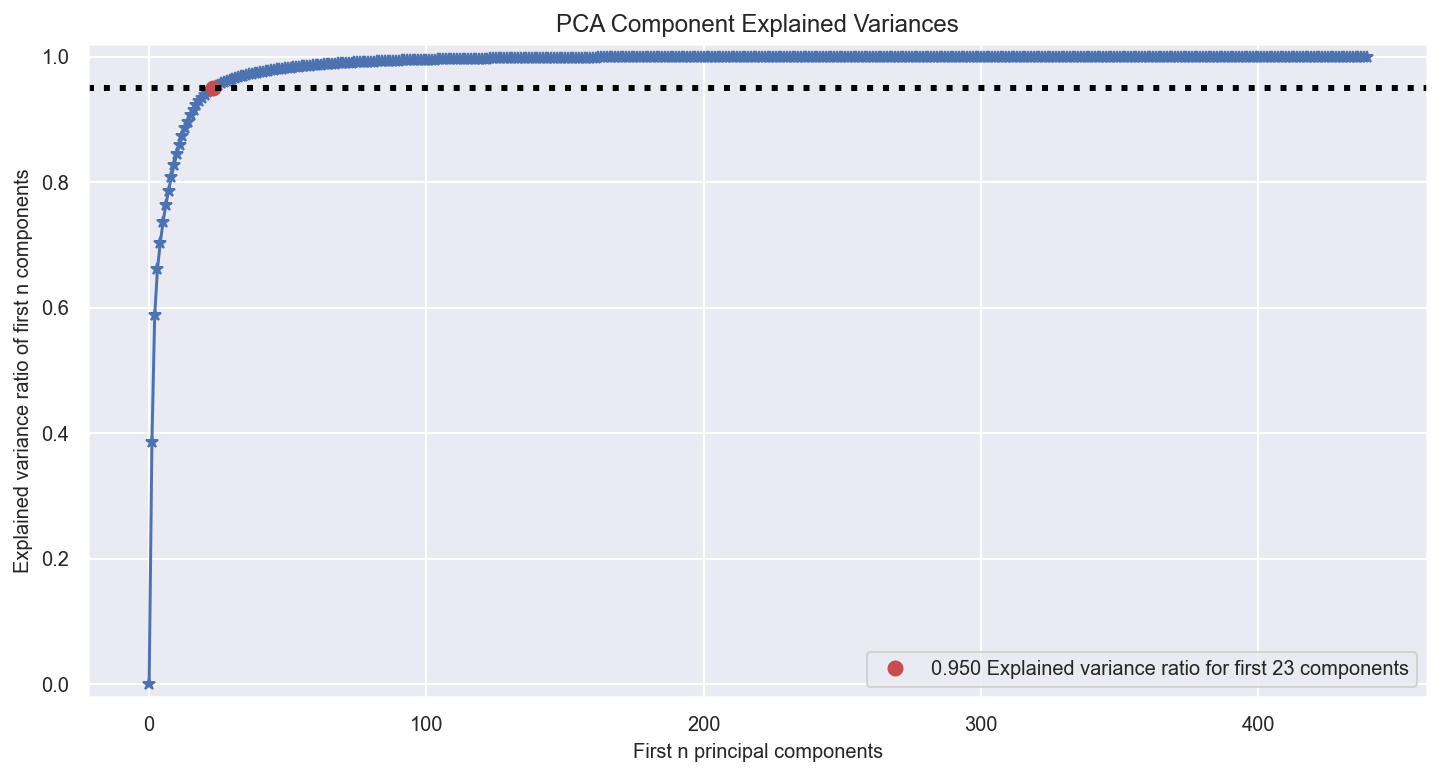

In [157]:
# Scree plot
from scikitplot.decomposition import plot_pca_component_variance, plot_pca_2d_projection

plot_pca_component_variance(pca, target_explained_variance=0.95, figsize=(12, 6))
plt.show()

In [158]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm



In [159]:
X_train.index.get_level_values('name')

Index(['Grant Long', 'Eric Piatkowski', 'Greg Anthony', 'Rik Smits',
       'Dennis Rodman', 'Luc Longley', 'Doug West', 'Jim McIlvaine',
       'Lorenzo Williams', 'Monty Williams',
       ...
       'William Howard', 'Nicolo Melli', 'Marko Guduric', 'Stanton Kidd',
       'Donta Hall', 'Matt Thomas', 'Tariq Owens', 'Javonte Green',
       'Juwan Morgan', 'Matt Mooney'],
      dtype='object', name='name', length=1991)

In [160]:
dict_encoded = X_pca.index.map(
    lambda x: position_dict[x[0]]).fillna('None').map({'G':0,'F':1,'C':2,
                                                       'G/F':3,'F/C':4,'G/F/C':5,
                                                       'None':6})

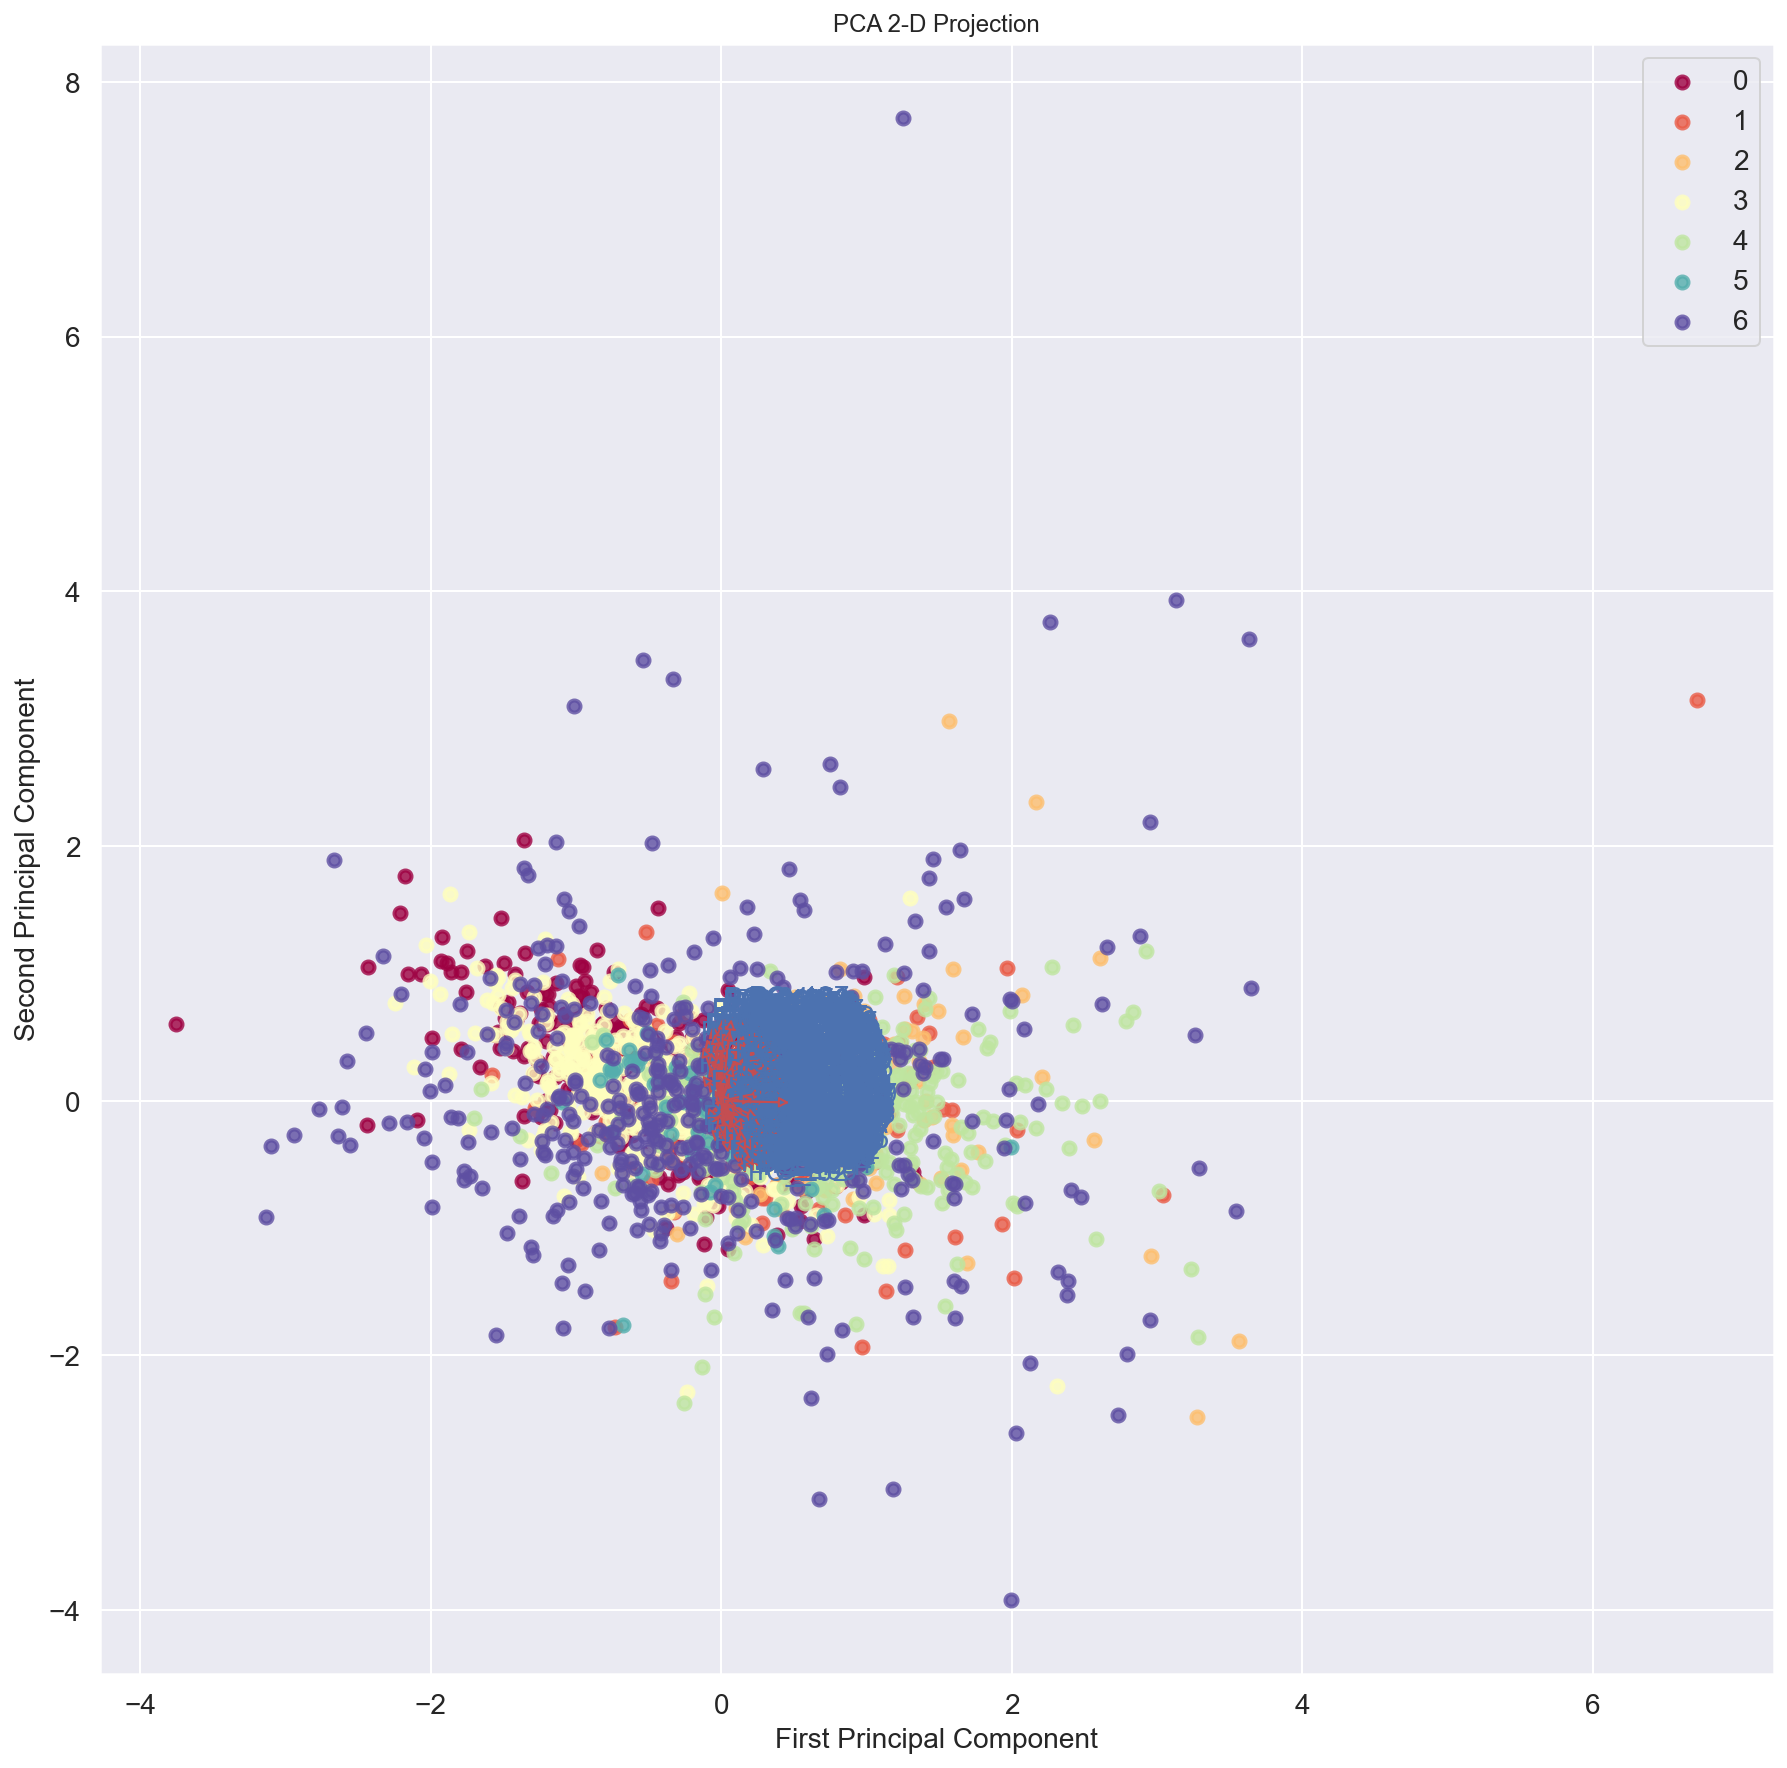

In [182]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_pca_2d_projection(pca, X_pca.iloc[:,:-1], dict_encoded, 
                       biplot=True,  
                       feature_labels=X_pca.columns.to_list(),
                       text_fontsize=14,
                       ax=ax)
ax.get_legend()
plt.show()

For n_clusters = 4 the average silhouette_score is: 0.1568143850524472


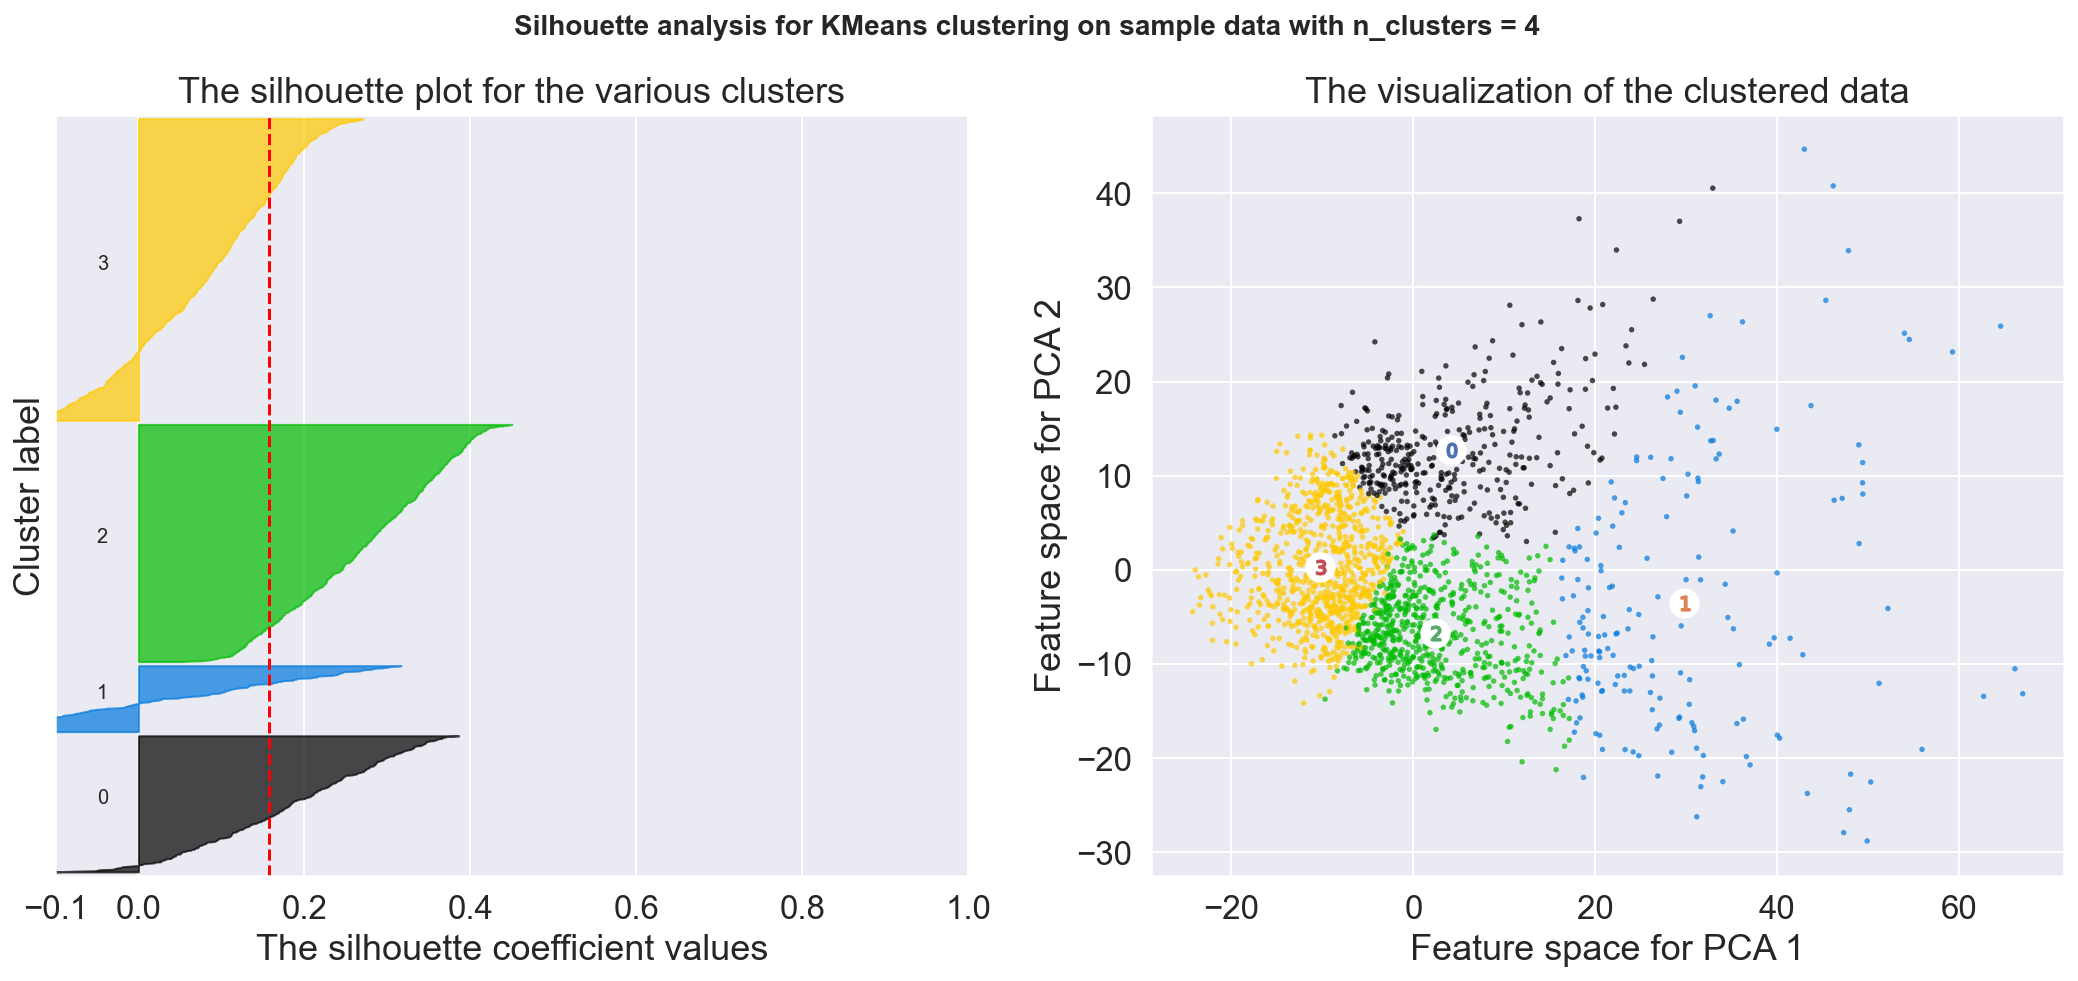

CLUSTER GROUP : 0 ['None' 'F' 'G/F' 'C' 'F/C' 'G/F/C'] 
Height mean & std : 2.09 0.05 
Second mean & std : 1236.12 291.34 
gPlayd mean & std : 346.11 279.97


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
2750,Pavel Podkolzin,2.000000,1,0.000000,0.000000,0.500000,1.200000,0,None
201182,Derrick Byars,-5.000000,1,0.222222,0.000000,1.000000,8.400000,0,None
1628451,Jacob Wiley,11.000000,1,0.333333,0.999999,0.500000,5.200000,0,None
201286,Eric Dawson,-25.000000,1,0.500000,0.000000,0.500000,5.700000,0,None
1629644,KZ Okpala,-8.000000,1,0.600000,0.000000,0.500000,8.500000,0,None
...,...,...,...,...,...,...,...,...,...
2403,Nene,2.118660,1045,0.546571,0.129627,0.655718,9.273971,0,F/C
1112,Ben Wallace,2.179607,1069,0.471220,0.114752,0.419904,9.338915,0,F/C
2585,Zaza Pachulia,0.138544,1126,0.469867,0.000000,0.751629,6.132238,0,F/C


CLUSTER GROUP : 1 ['G' 'G/F' 'F' 'F/C' 'G/F/C' 'C'] 
Height mean & std : 1.99 0.09 
Second mean & std : 1962.86 180.66 
gPlayd mean & std : 677.49 374.71


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
204054,Zoran Dragic,-5.000000,1,0.529412,0.428571,0.500000,14.200000,1,G
1629045,Bonzie Colson,-1.000000,2,0.352941,0.222222,0.888889,14.750000,1,G/F
787,Charles Barkley,-0.250000,20,0.477477,0.230769,0.645454,12.460000,1,F
1629627,Zion Williamson,2.583333,24,0.583333,0.428571,0.640449,16.604167,1,F
1629628,RJ Barrett,-5.821429,56,0.401651,0.319797,0.614173,8.385714,1,G
...,...,...,...,...,...,...,...,...,...
2225,Tony Parker,4.235493,1482,0.485859,0.320963,0.747772,11.656478,1,G
1495,Tim Duncan,6.118439,1486,0.502413,0.186812,0.696436,16.433647,1,F/C
2544,LeBron James,5.345574,1525,0.502237,0.342255,0.735652,22.463738,1,G/F


CLUSTER GROUP : 2 ['None' 'F' 'G' 'G/F' 'F/C' 'G/F/C'] 
Height mean & std : 1.94 0.08 
Second mean & std : 1345.26 262.76 
gPlayd mean & std : 332.98 286.14


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1628935,Aaron Jackson,-10.000000,1,0.333333,0.250000,0.500000,2.300000,2,None
202077,Jerel McNeal,-1.000000,2,0.333333,0.999998,0.999999,1.700000,2,None
1629677,Luka Samanic,6.500000,2,0.357143,0.428571,0.750000,6.450000,2,F
202810,D.J. Kennedy,-16.000000,2,0.416667,0.500000,0.000000,2.800000,2,None
1629625,Justin Wright-Foreman,-10.666667,3,0.350000,0.200000,0.749999,3.600000,2,None
...,...,...,...,...,...,...,...,...,...
2210,Richard Jefferson,0.702808,1282,0.465080,0.372383,0.765151,8.959828,2,G/F
965,Derek Fisher,3.284178,1302,0.402257,0.380203,0.830011,6.516129,2,G/F
2594,Kyle Korver,2.364243,1348,0.440310,0.425244,0.879012,6.898368,2,G/F


CLUSTER GROUP : 3 ['None' 'F' 'G' 'C' 'F/C' 'G/F' 'G/F/C'] 
Height mean & std : 2.01 0.09 
Second mean & std : 789.5 213.07 
gPlayd mean & std : 68.3 109.43


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1629760,Matt Mooney,6.000000,1,0.000000,0.000000,0.000000,0.200000,3,None
202197,Shane Edwards,-5.000000,1,0.500000,0.000000,0.000000,-0.100000,3,None
1629122,J.P. Macura,-7.000000,1,0.250000,0.000000,0.000000,1.200000,3,None
1629116,Angel Delgado,-1.000000,1,0.250000,0.000000,0.500000,2.400000,3,None
202385,Ryan Reid,-5.000000,1,1.000000,0.000000,0.000000,3.000000,3,None
...,...,...,...,...,...,...,...,...,...
2059,Eduardo Najera,1.404568,613,0.478474,0.311294,0.677230,4.685155,3,G/F/C
201973,Jonas Jerebko,-0.178683,638,0.458132,0.362054,0.773367,5.111755,3,F/C
201967,Dante Cunningham,-1.284884,688,0.470947,0.345659,0.652849,5.055959,3,F/C


For n_clusters = 5 the average silhouette_score is: 0.15987569103349147


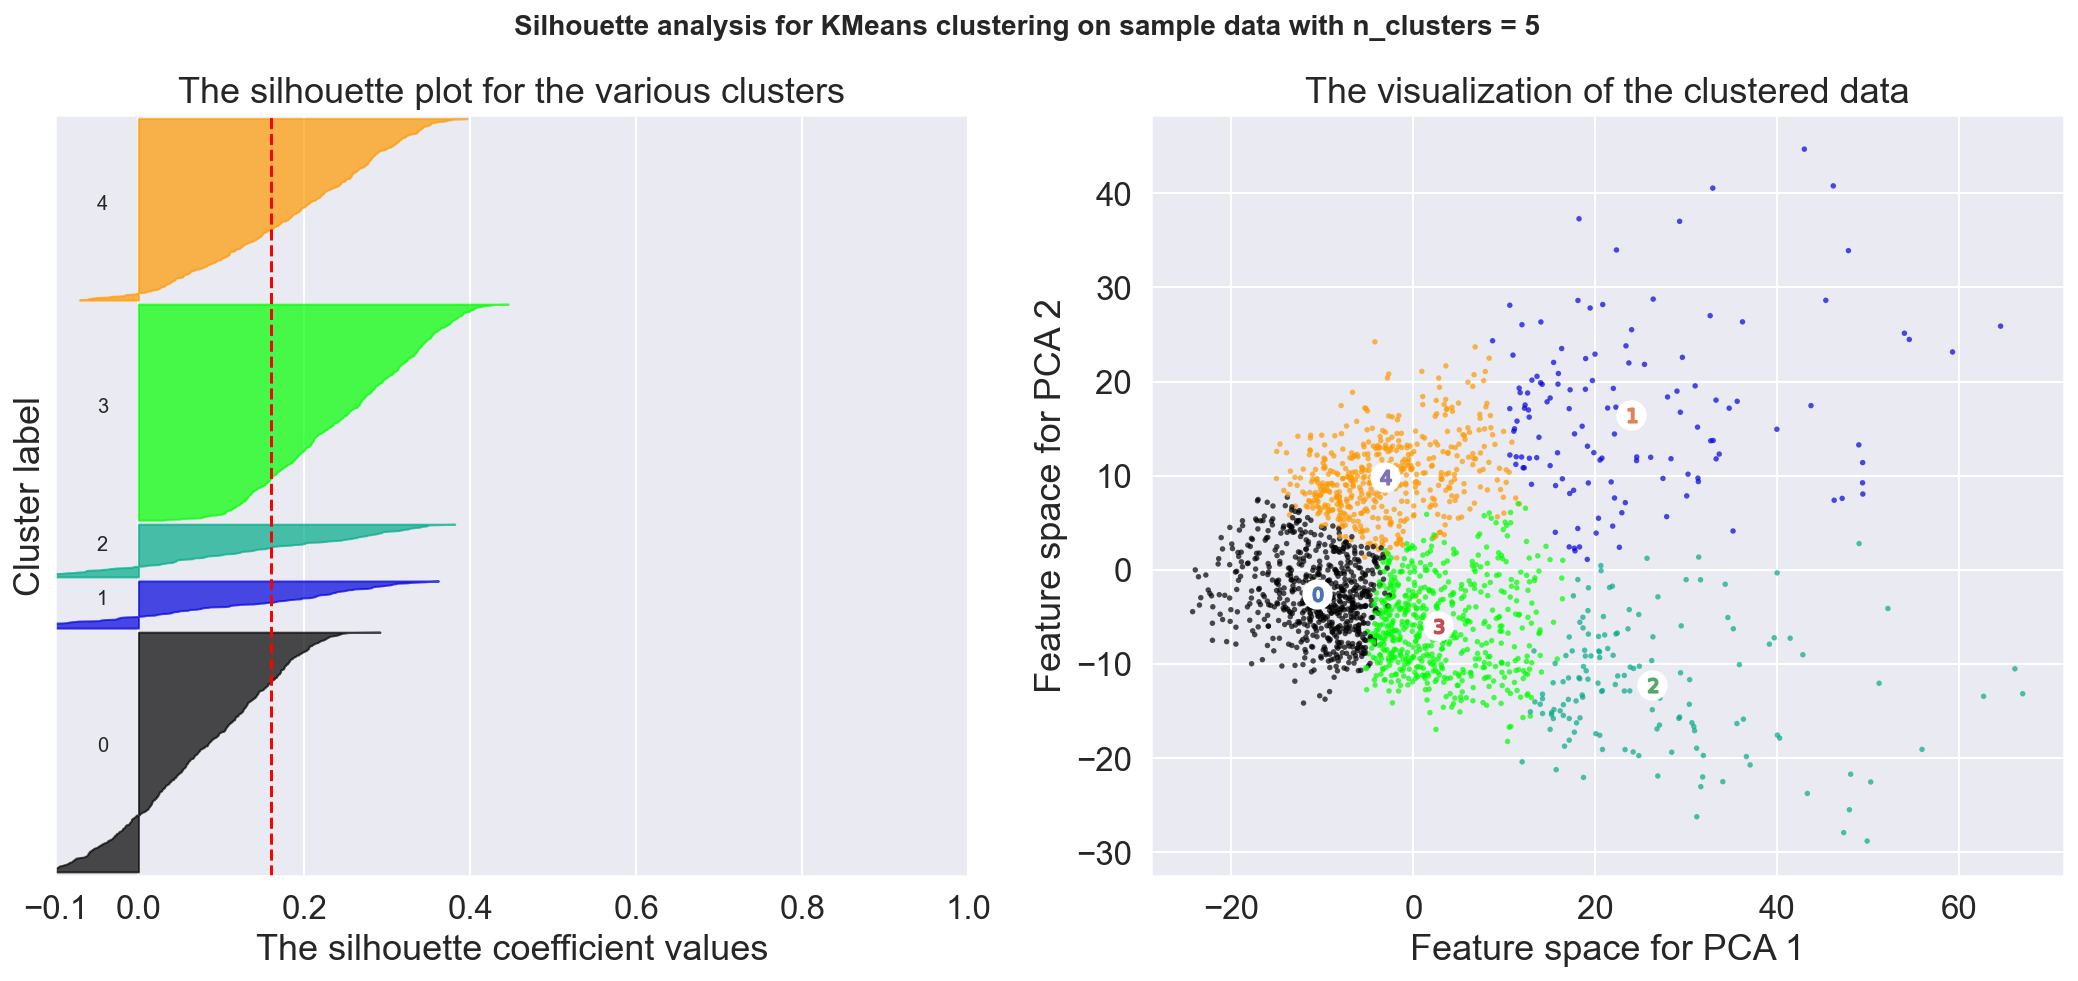

CLUSTER GROUP : 0 ['None' 'F' 'G' 'C' 'F/C' 'G/F' 'G/F/C'] 
Height mean & std : 1.98 0.08 
Second mean & std : 796.03 222.29 
gPlayd mean & std : 59.69 102.12


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1629760,Matt Mooney,6.000000,1,0.000000,0.000000,0.000000,0.200000,0,None
200799,Guillermo Diaz,-4.000000,1,0.000000,0.000000,0.000000,0.700000,0,None
1619,Kiwane Garris,10.000000,1,0.222222,0.000000,0.000000,-0.800000,0,None
1585,Brandon Williams,-6.000000,1,0.000000,0.000000,0.000000,-1.800000,0,None
200840,Chris McCray,-7.000000,1,0.000000,0.000000,0.000000,-3.800000,0,None
...,...,...,...,...,...,...,...,...,...
2230,Maurice Evans,-0.407534,584,0.443830,0.366219,0.783521,4.824658,0,G/F
201967,Dante Cunningham,-1.284884,688,0.470947,0.345659,0.652849,5.055959,0,F/C
2592,James Jones,1.055152,689,0.402836,0.399054,0.843242,4.171408,0,G/F


CLUSTER GROUP : 1 ['G/F' 'None' 'F' 'F/C' 'C' 'G/F/C'] 
Height mean & std : 2.09 0.05 
Second mean & std : 1751.49 235.61 
gPlayd mean & std : 613.55 356.6


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1629045,Bonzie Colson,-1.000000,2,0.352941,0.222222,0.888889,14.750000,1,G/F
2569,Ndudi Ebi,7.000000,2,0.523809,0.000000,0.555555,9.450000,1,None
1629203,Jemerrio Jones,5.600000,5,0.375000,0.222222,0.499999,8.140000,1,F
23,Dennis Rodman,-6.333333,12,0.387097,0.000000,0.714285,5.258333,1,F
787,Charles Barkley,-0.250000,20,0.477477,0.230769,0.645454,12.460000,1,F
...,...,...,...,...,...,...,...,...,...
1890,Shawn Marion,1.662975,1264,0.482091,0.329889,0.810372,13.177057,1,G/F
708,Kevin Garnett,3.812117,1304,0.497250,0.276948,0.799515,16.110353,1,F/C
2200,Pau Gasol,1.523915,1359,0.507416,0.363288,0.752379,14.724062,1,F/C


CLUSTER GROUP : 2 ['G' 'G/F' 'F' 'G/F/C' 'F/C'] 
Height mean & std : 1.94 0.07 
Second mean & std : 1938.18 200.47 
gPlayd mean & std : 666.34 353.21


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
204054,Zoran Dragic,-5.000000,1,0.529412,0.428571,0.500000,14.200000,2,G
1629628,RJ Barrett,-5.821429,56,0.401651,0.319797,0.614173,8.385714,2,G
1629630,Ja Morant,-0.253731,67,0.477054,0.335195,0.775974,13.949254,2,G
1628984,Devonte' Graham,-2.728155,103,0.374150,0.356534,0.810036,9.987379,2,G
203100,Tony Wroten,-5.706767,133,0.413967,0.232044,0.646853,6.918797,2,G
...,...,...,...,...,...,...,...,...,...
2207,Joe Johnson,0.429806,1389,0.440322,0.368612,0.800367,11.081353,2,G/F
1718,Paul Pierce,2.442466,1460,0.443068,0.365701,0.811086,13.980685,2,G/F
2225,Tony Parker,4.235493,1482,0.485859,0.320963,0.747772,11.656478,2,G


CLUSTER GROUP : 3 ['None' 'F' 'G' 'G/F' 'C' 'F/C' 'G/F/C'] 
Height mean & std : 1.95 0.08 
Second mean & std : 1364.72 241.24 
gPlayd mean & std : 340.13 280.33


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1628935,Aaron Jackson,-10.000000,1,0.333333,0.250000,0.500000,2.300000,3,None
1628451,Jacob Wiley,11.000000,1,0.333333,0.999999,0.500000,5.200000,3,None
201182,Derrick Byars,-5.000000,1,0.222222,0.000000,1.000000,8.400000,3,None
202810,D.J. Kennedy,-16.000000,2,0.416667,0.500000,0.000000,2.800000,3,None
202077,Jerel McNeal,-1.000000,2,0.333333,0.999998,0.999999,1.700000,3,None
...,...,...,...,...,...,...,...,...,...
2564,Boris Diaw,1.364646,1171,0.495174,0.336977,0.719235,7.442272,3,G/F/C
2210,Richard Jefferson,0.702808,1282,0.465080,0.372383,0.765151,8.959828,3,G/F
965,Derek Fisher,3.284178,1302,0.402257,0.380203,0.830011,6.516129,3,G/F


CLUSTER GROUP : 4 ['None' 'F' 'C' 'G/F' 'F/C' 'G' 'G/F/C'] 
Height mean & std : 2.09 0.05 
Second mean & std : 992.28 261.53 
gPlayd mean & std : 212.18 227.68


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1628493,Mangok Mathiang,3.000000,1,0.800000,0.000000,0.000000,7.500000,4,None
1628450,Eric Mika,8.000000,1,0.666666,0.000000,1.000000,5.600000,4,None
1627754,Diamond Stone,-8.000000,1,0.333333,0.000000,1.000000,3.100000,4,None
201286,Eric Dawson,-25.000000,1,0.500000,0.000000,0.500000,5.700000,4,None
101213,Sharrod Ford,-12.000000,1,0.999999,0.000000,0.000000,0.100000,4,None
...,...,...,...,...,...,...,...,...,...
1737,Nazr Mohammed,-0.844027,904,0.491881,0.222200,0.640964,5.341593,4,F/C
2617,Udonis Haslem,0.549206,945,0.489678,0.062499,0.751606,6.518730,4,F/C
2555,Nick Collison,1.343035,962,0.536183,0.224297,0.721396,5.465696,4,F/C


For n_clusters = 6 the average silhouette_score is: 0.16996141449111904


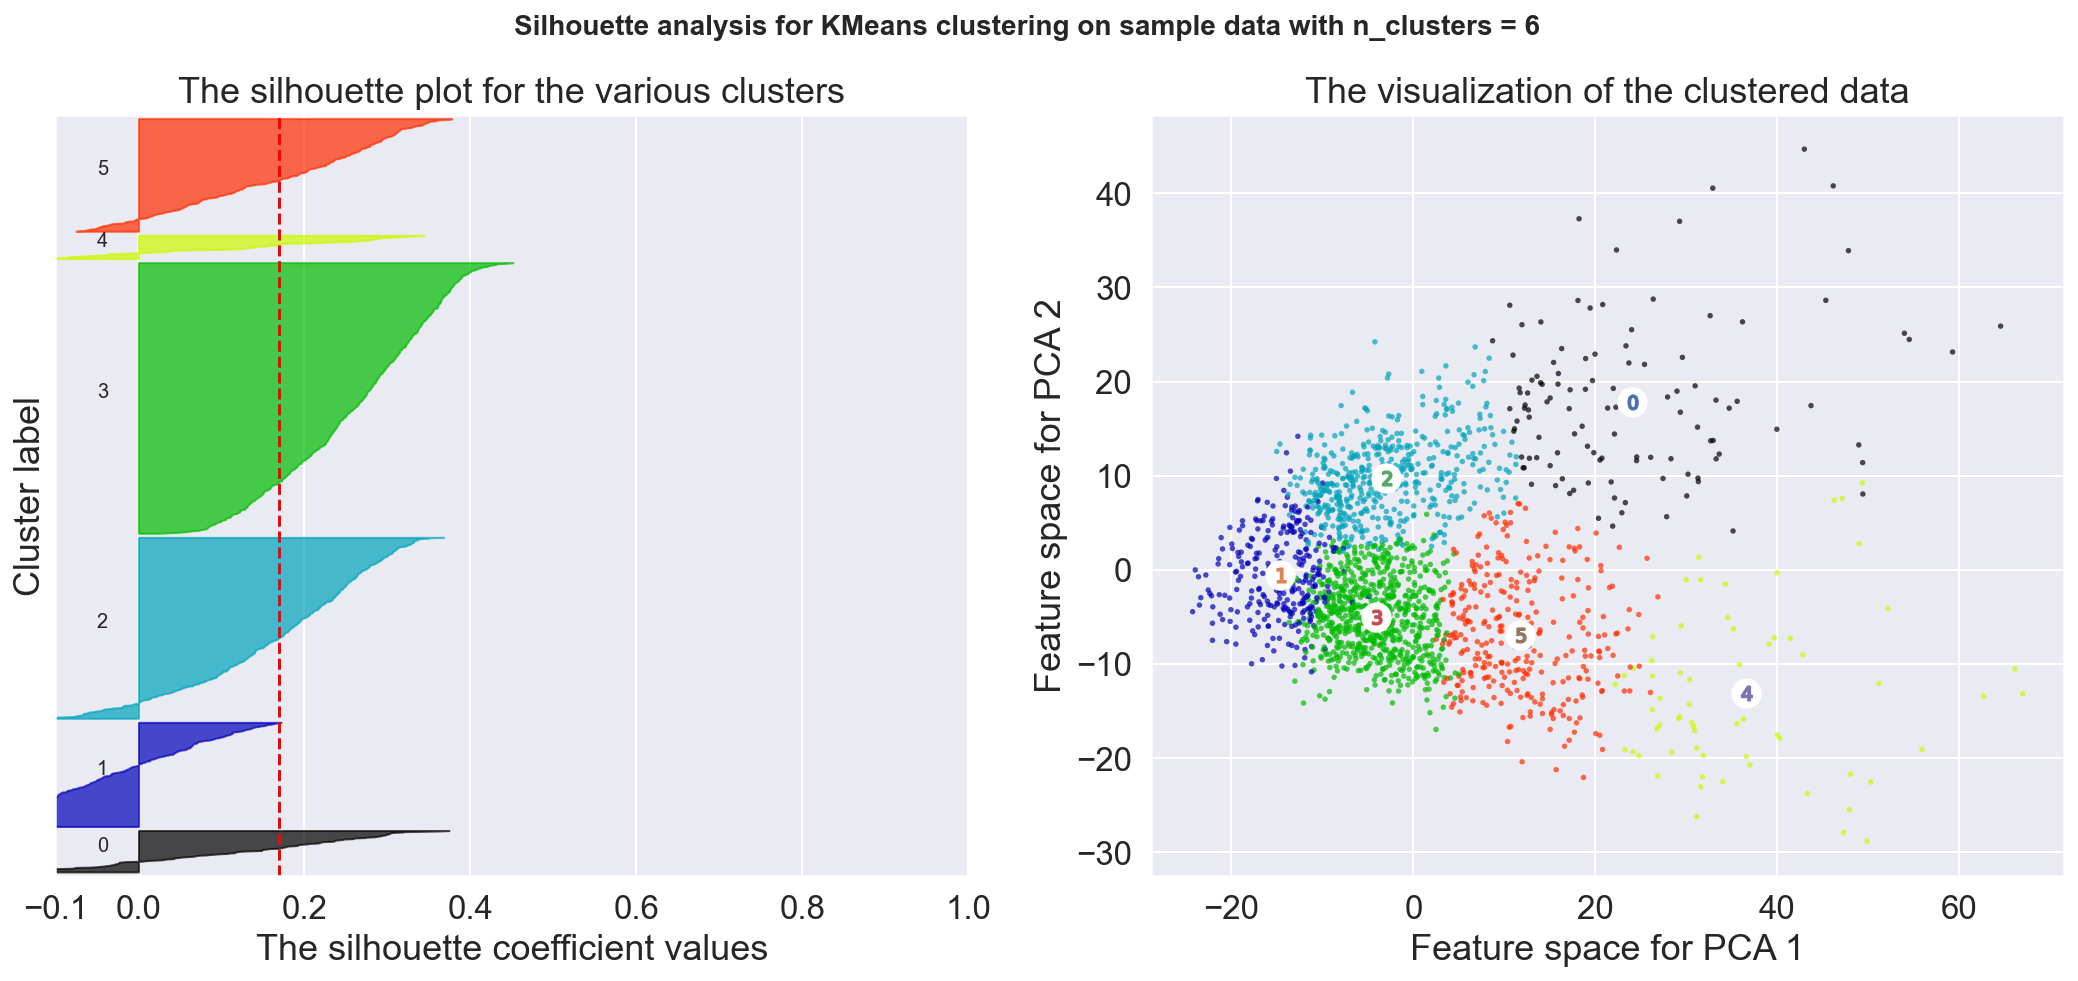

CLUSTER GROUP : 0 ['None' 'G/F' 'F' 'F/C' 'C' 'G/F/C'] 
Height mean & std : 2.09 0.05 
Second mean & std : 1751.81 234.01 
gPlayd mean & std : 628.81 362.74


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
2569,Ndudi Ebi,7.000000,2,0.523809,0.000000,0.555555,9.450000,0,None
1629045,Bonzie Colson,-1.000000,2,0.352941,0.222222,0.888889,14.750000,0,G/F
1629203,Jemerrio Jones,5.600000,5,0.375000,0.222222,0.499999,8.140000,0,F
23,Dennis Rodman,-6.333333,12,0.387097,0.000000,0.714285,5.258333,0,F
787,Charles Barkley,-0.250000,20,0.477477,0.230769,0.645454,12.460000,0,F
...,...,...,...,...,...,...,...,...,...
1890,Shawn Marion,1.662975,1264,0.482091,0.329889,0.810372,13.177057,0,G/F
708,Kevin Garnett,3.812117,1304,0.497250,0.276948,0.799515,16.110353,0,F/C
2200,Pau Gasol,1.523915,1359,0.507416,0.363288,0.752379,14.724062,0,F/C


CLUSTER GROUP : 1 ['None' 'F' 'G' 'C' 'F/C' 'G/F' 'G/F/C'] 
Height mean & std : 2.0 0.08 
Second mean & std : 651.96 202.43 
gPlayd mean & std : 15.07 24.53


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1629760,Matt Mooney,6.000000,1,0.000000,0.000000,0.000000,0.200000,1,None
1754,Andrae Patterson,4.000000,1,0.999999,0.000000,0.000000,1.300000,1,None
203122,Kevin Murphy,-11.000000,1,0.666667,0.999999,0.000000,6.700000,1,None
1844,Fred Vinson,18.000000,1,1.000000,0.999999,0.000000,7.100000,1,None
203130,Darius Johnson-Odom,-3.000000,1,0.000000,0.000000,0.000000,-3.800000,1,None
...,...,...,...,...,...,...,...,...,...
1626173,Rashad Vaughn,-1.653465,101,0.341357,0.330709,0.692305,2.331683,1,G
203103,Perry Jones III,-0.743119,109,0.418502,0.296875,0.662790,2.711009,1,G/F
204014,Damjan Rudez,-0.017699,113,0.432570,0.390334,0.774191,2.324779,1,G


CLUSTER GROUP : 2 ['None' 'F' 'C' 'G/F' 'G' 'F/C' 'G/F/C'] 
Height mean & std : 2.09 0.05 
Second mean & std : 991.95 261.44 
gPlayd mean & std : 212.92 228.25


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
101232,Roger Powell,-9.000000,1,0.000000,0.000000,1.000000,-0.100000,2,None
1629644,KZ Okpala,-8.000000,1,0.600000,0.000000,0.500000,8.500000,2,None
201286,Eric Dawson,-25.000000,1,0.500000,0.000000,0.500000,5.700000,2,None
101213,Sharrod Ford,-12.000000,1,0.999999,0.000000,0.000000,0.100000,2,None
1628450,Eric Mika,8.000000,1,0.666666,0.000000,1.000000,5.600000,2,None
...,...,...,...,...,...,...,...,...,...
1737,Nazr Mohammed,-0.844027,904,0.491881,0.222200,0.640964,5.341593,2,F/C
2617,Udonis Haslem,0.549206,945,0.489678,0.062499,0.751606,6.518730,2,F/C
2555,Nick Collison,1.343035,962,0.536183,0.224297,0.721396,5.465696,2,F/C


CLUSTER GROUP : 3 ['None' 'F' 'G' 'F/C' 'G/F' 'C' 'G/F/C'] 
Height mean & std : 1.95 0.08 
Second mean & std : 1073.56 233.65 
gPlayd mean & std : 183.54 205.06


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
201802,Oliver Lafayette,-9.000000,1,0.500000,0.500000,0.000000,6.000000,3,None
2657,Yuta Tabuse,-8.000000,1,0.333333,0.999999,1.000000,4.600000,3,None
1628935,Aaron Jackson,-10.000000,1,0.333333,0.250000,0.500000,2.300000,3,None
1628505,Troy Caupain,10.000000,1,0.666666,0.999999,0.000000,6.400000,3,None
1628451,Jacob Wiley,11.000000,1,0.333333,0.999999,0.500000,5.200000,3,None
...,...,...,...,...,...,...,...,...,...
2754,Tony Allen,1.046980,894,0.472815,0.265306,0.710963,6.371477,3,G/F
2581,Steve Blake,-0.483480,908,0.400860,0.383069,0.776275,5.483370,3,G
200757,Thabo Sefolosha,1.082147,913,0.446343,0.343712,0.736676,5.451698,3,G/F


CLUSTER GROUP : 4 ['G' 'G/F' 'F' 'F/C' 'G/F/C'] 
Height mean & std : 1.94 0.08 
Second mean & std : 2038.86 159.94 
gPlayd mean & std : 686.73 352.01


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1629630,Ja Morant,-0.253731,67,0.477054,0.335195,0.775974,13.949254,4,G
1629029,Luka Doncic,0.731884,138,0.448209,0.323315,0.732191,19.328261,4,G/F
1629027,Trae Young,-3.992908,141,0.427545,0.343809,0.846865,17.412057,4,G
893,Michael Jordan,0.226950,141,0.431842,0.240740,0.805513,14.104255,4,G/F
1628366,Lonzo Ball,-0.376543,162,0.389572,0.340959,0.487179,10.077778,4,G/F
...,...,...,...,...,...,...,...,...,...
2548,Dwyane Wade,2.650407,1230,0.478940,0.299220,0.766901,16.551626,4,G/F
977,Kobe Bryant,3.232263,1339,0.448281,0.329956,0.836343,18.923600,4,G/F
1889,Andre Miller,0.442478,1356,0.459838,0.227848,0.805721,11.165118,4,G


CLUSTER GROUP : 5 ['None' 'G' 'F' 'C' 'F/C' 'G/F' 'G/F/C'] 
Height mean & std : 1.97 0.07 
Second mean & std : 1667.46 216.46 
gPlayd mean & std : 510.35 336.32


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
201182,Derrick Byars,-5.000000,1,0.222222,0.000000,1.000000,8.400000,5,None
204054,Zoran Dragic,-5.000000,1,0.529412,0.428571,0.500000,14.200000,5,G
1628504,Xavier Rathan-Mayes,-11.800000,5,0.285714,0.071429,0.444444,1.280000,5,None
1628539,Mychal Mulder,3.285714,7,0.388060,0.307692,0.750000,6.100000,5,G
1627215,Walt Lemon Jr.,-2.888889,9,0.444444,0.499999,0.714285,8.222222,5,G
...,...,...,...,...,...,...,...,...,...
2037,Jamal Crawford,-0.938761,1388,0.408819,0.345982,0.862191,9.584006,5,G/F
2207,Joe Johnson,0.429806,1389,0.440322,0.368612,0.800367,11.081353,5,G/F
2225,Tony Parker,4.235493,1482,0.485859,0.320963,0.747772,11.656478,5,G


For n_clusters = 7 the average silhouette_score is: 0.16801889171370352


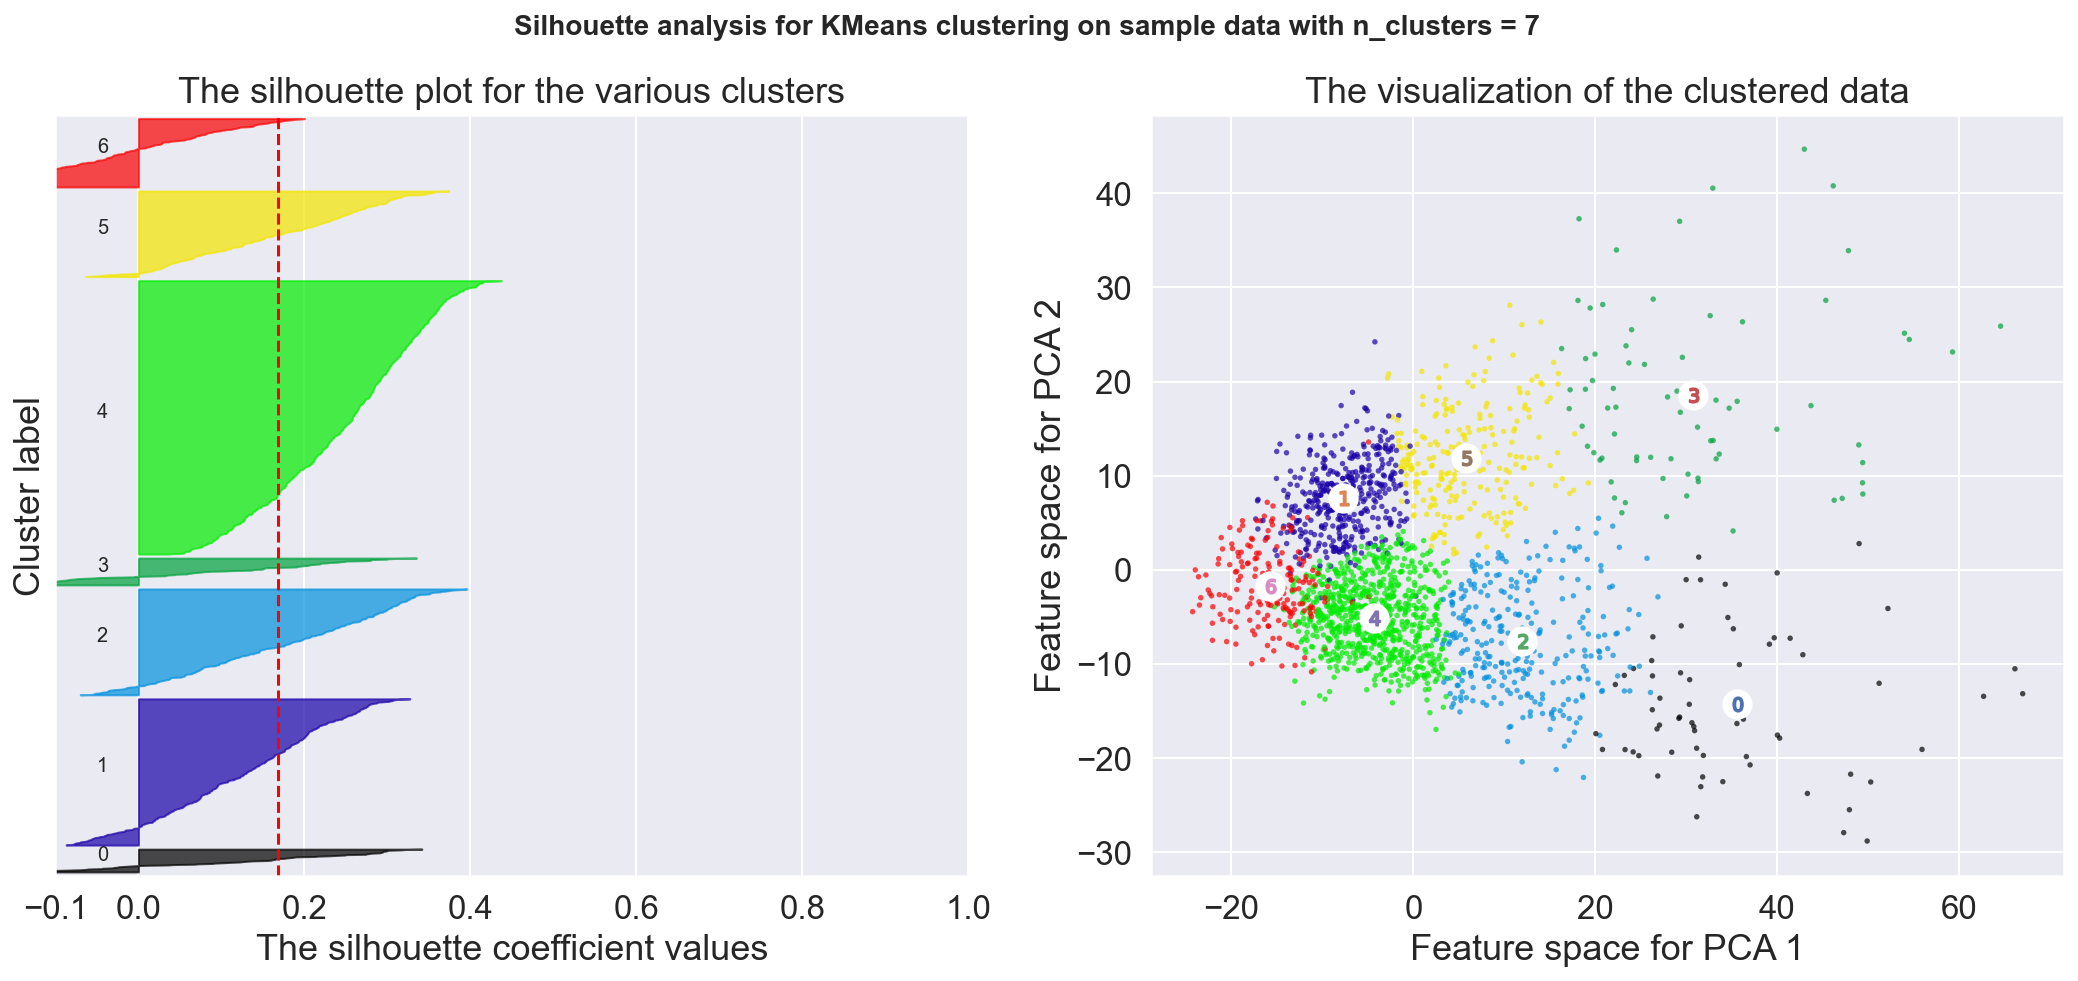

CLUSTER GROUP : 0 ['G' 'G/F' 'F' 'F/C' 'G/F/C'] 
Height mean & std : 1.93 0.07 
Second mean & std : 2031.08 164.15 
gPlayd mean & std : 695.76 351.85


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1629630,Ja Morant,-0.253731,67,0.477054,0.335195,0.775974,13.949254,0,G
1629029,Luka Doncic,0.731884,138,0.448209,0.323315,0.732191,19.328261,0,G/F
1629027,Trae Young,-3.992908,141,0.427545,0.343809,0.846865,17.412057,0,G
893,Michael Jordan,0.226950,141,0.431842,0.240740,0.805513,14.104255,0,G/F
1628366,Lonzo Ball,-0.376543,162,0.389572,0.340959,0.487179,10.077778,0,G/F
...,...,...,...,...,...,...,...,...,...
2548,Dwyane Wade,2.650407,1230,0.478940,0.299220,0.766901,16.551626,0,G/F
977,Kobe Bryant,3.232263,1339,0.448281,0.329956,0.836343,18.923600,0,G/F
1889,Andre Miller,0.442478,1356,0.459838,0.227848,0.805721,11.165118,0,G


CLUSTER GROUP : 1 ['None' 'F' 'C' 'F/C' 'G' 'G/F' 'G/F/C'] 
Height mean & std : 2.08 0.06 
Second mean & std : 817.58 181.49 
gPlayd mean & std : 99.46 129.58


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
101213,Sharrod Ford,-12.000000,1,0.999999,0.000000,0.000000,0.100000,1,None
2237,Ratko Varda,-1.000000,1,0.666666,0.000000,0.999999,1.800000,1,None
2442,Chris Owens,6.000000,1,0.666666,0.000000,0.000000,2.400000,1,None
101232,Roger Powell,-9.000000,1,0.000000,0.000000,1.000000,-0.100000,1,None
1627754,Diamond Stone,-8.000000,1,0.333333,0.000000,1.000000,3.100000,1,None
...,...,...,...,...,...,...,...,...,...
201160,Jason Smith,-1.210256,585,0.471603,0.338709,0.784011,4.603761,1,F/C
101131,Jason Maxiell,-1.090610,607,0.503975,0.000000,0.563593,4.936738,1,F/C
2059,Eduardo Najera,1.404568,613,0.478474,0.311294,0.677230,4.685155,1,G/F/C


CLUSTER GROUP : 2 ['G' 'None' 'F' 'F/C' 'G/F' 'G/F/C'] 
Height mean & std : 1.96 0.07 
Second mean & std : 1677.07 214.75 
gPlayd mean & std : 517.19 338.88


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
204054,Zoran Dragic,-5.000000,1,0.529412,0.428571,0.500000,14.200000,2,G
1628504,Xavier Rathan-Mayes,-11.800000,5,0.285714,0.071429,0.444444,1.280000,2,None
1628539,Mychal Mulder,3.285714,7,0.388060,0.307692,0.750000,6.100000,2,G
1627215,Walt Lemon Jr.,-2.888889,9,0.444444,0.499999,0.714285,8.222222,2,G
1629640,Keldon Johnson,4.461538,13,0.607143,0.590909,0.795454,9.992308,2,F
...,...,...,...,...,...,...,...,...,...
2037,Jamal Crawford,-0.938761,1388,0.408819,0.345982,0.862191,9.584006,2,G/F
2207,Joe Johnson,0.429806,1389,0.440322,0.368612,0.800367,11.081353,2,G/F
2225,Tony Parker,4.235493,1482,0.485859,0.320963,0.747772,11.656478,2,G


CLUSTER GROUP : 3 ['G/F' 'F' 'F/C' 'C' 'G/F/C'] 
Height mean & std : 2.09 0.05 
Second mean & std : 1868.51 202.27 
gPlayd mean & std : 675.53 378.58


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1629045,Bonzie Colson,-1.000000,2,0.352941,0.222222,0.888889,14.750000,3,G/F
23,Dennis Rodman,-6.333333,12,0.387097,0.000000,0.714285,5.258333,3,F
787,Charles Barkley,-0.250000,20,0.477477,0.230769,0.645454,12.460000,3,F
1629627,Zion Williamson,2.583333,24,0.583333,0.428571,0.640449,16.604167,3,F
1628963,Marvin Bagley III,-2.560000,75,0.497136,0.288135,0.703071,11.205333,3,F/C
...,...,...,...,...,...,...,...,...,...
1890,Shawn Marion,1.662975,1264,0.482091,0.329889,0.810372,13.177057,3,G/F
708,Kevin Garnett,3.812117,1304,0.497250,0.276948,0.799515,16.110353,3,F/C
2200,Pau Gasol,1.523915,1359,0.507416,0.363288,0.752379,14.724062,3,F/C


CLUSTER GROUP : 4 ['None' 'F' 'G' 'G/F' 'F/C' 'C' 'G/F/C'] 
Height mean & std : 1.95 0.08 
Second mean & std : 1065.46 239.98 
gPlayd mean & std : 179.54 202.03


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
201802,Oliver Lafayette,-9.000000,1,0.500000,0.500000,0.000000,6.000000,4,None
203317,Tim Ohlbrecht,-4.000000,1,0.500000,0.000000,0.999999,2.300000,4,None
1628505,Troy Caupain,10.000000,1,0.666666,0.999999,0.000000,6.400000,4,None
2657,Yuta Tabuse,-8.000000,1,0.333333,0.999999,1.000000,4.600000,4,None
1628935,Aaron Jackson,-10.000000,1,0.333333,0.250000,0.500000,2.300000,4,None
...,...,...,...,...,...,...,...,...,...
1477,Bruce Bowen,3.038117,892,0.409135,0.400333,0.568548,4.511547,4,G/F
2581,Steve Blake,-0.483480,908,0.400860,0.383069,0.776275,5.483370,4,G
200757,Thabo Sefolosha,1.082147,913,0.446343,0.343712,0.736676,5.451698,4,G/F


CLUSTER GROUP : 5 ['None' 'F' 'G/F' 'F/C' 'C' 'G/F/C'] 
Height mean & std : 2.08 0.05 
Second mean & std : 1317.14 221.59 
gPlayd mean & std : 412.01 274.87


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
201182,Derrick Byars,-5.000000,1,0.222222,0.000000,1.000000,8.400000,5,None
1628451,Jacob Wiley,11.000000,1,0.333333,0.999999,0.500000,5.200000,5,None
1628450,Eric Mika,8.000000,1,0.666666,0.000000,1.000000,5.600000,5,None
201286,Eric Dawson,-25.000000,1,0.500000,0.000000,0.500000,5.700000,5,None
2569,Ndudi Ebi,7.000000,2,0.523809,0.000000,0.555555,9.450000,5,None
...,...,...,...,...,...,...,...,...,...
703,Kurt Thomas,0.499499,999,0.488898,0.299990,0.782458,6.787588,5,F/C
2403,Nene,2.118660,1045,0.546571,0.129627,0.655718,9.273971,5,F/C
2585,Zaza Pachulia,0.138544,1126,0.469867,0.000000,0.751629,6.132238,5,F/C


CLUSTER GROUP : 6 ['None' 'F' 'G' 'C' 'G/F'] 
Height mean & std : 2.0 0.08 
Second mean & std : 637.12 224.75 
gPlayd mean & std : 8.34 15.76


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1629760,Matt Mooney,6.000000,1,0.000000,0.000000,0.000000,0.200000,6,None
2123,Garth Joseph,2.000000,1,0.000000,0.000000,0.000000,-2.500000,6,None
1628968,Brian Bowen II,3.000000,1,0.000000,0.000000,0.000000,-3.000000,6,F
1628769,Tahjere McCall,15.000000,1,0.666666,0.000000,0.000000,1.800000,6,None
1628500,Ben Moore,-1.000000,1,0.000000,0.000000,0.000000,-0.500000,6,None
...,...,...,...,...,...,...,...,...,...
2220,Brandon Armstrong,-2.113208,53,0.330435,0.310345,0.529410,1.028302,6,None
203923,James Young,-1.258065,62,0.363636,0.276923,0.549999,2.054839,6,None
203962,Josh Huestis,1.728571,70,0.336683,0.296610,0.260869,1.914286,6,G


For n_clusters = 8 the average silhouette_score is: 0.13933219158800236


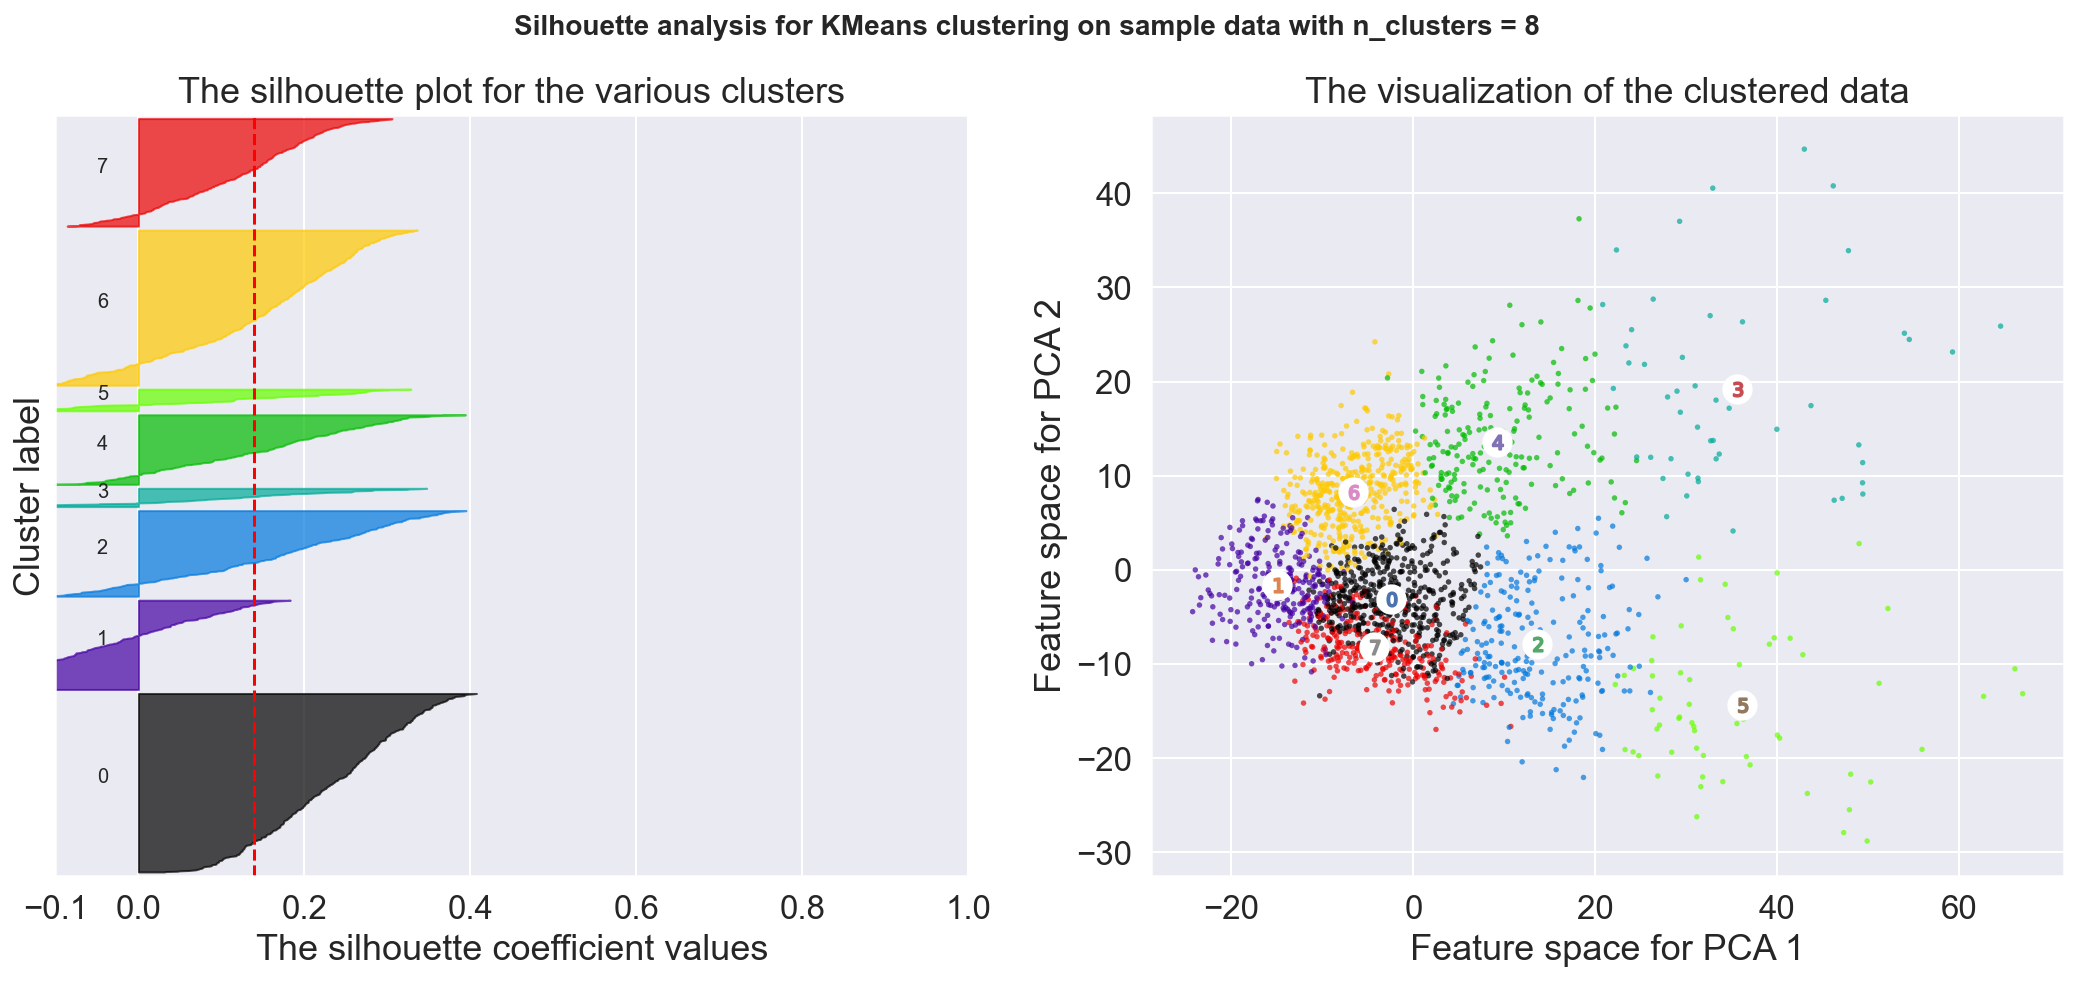

CLUSTER GROUP : 0 ['None' 'F' 'G' 'G/F' 'F/C' 'C' 'G/F/C'] 
Height mean & std : 1.99 0.06 
Second mean & std : 1191.21 226.51 
gPlayd mean & std : 240.82 238.69


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
201802,Oliver Lafayette,-9.000000,1,0.500000,0.500000,0.000000,6.000000,0,None
2657,Yuta Tabuse,-8.000000,1,0.333333,0.999999,1.000000,4.600000,0,None
1629644,KZ Okpala,-8.000000,1,0.600000,0.000000,0.500000,8.500000,0,None
1628935,Aaron Jackson,-10.000000,1,0.333333,0.250000,0.500000,2.300000,0,None
200970,Renaldo Major,15.000000,1,0.200000,0.000000,0.500000,-1.600000,0,None
...,...,...,...,...,...,...,...,...,...
2440,Matt Barnes,1.344793,989,0.433659,0.331882,0.746675,6.431547,0,G/F/C
2203,Shane Battier,2.153562,1081,0.434376,0.381319,0.746225,7.370398,0,G/F
101107,Marvin Williams,-0.602655,1130,0.440234,0.362075,0.808934,7.882655,0,G/F


CLUSTER GROUP : 1 ['None' 'F' 'G' 'C' 'F/C' 'G/F'] 
Height mean & std : 2.0 0.08 
Second mean & std : 650.64 203.82 
gPlayd mean & std : 14.06 23.96


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1629760,Matt Mooney,6.000000,1,0.000000,0.000000,0.000000,0.200000,1,None
200799,Guillermo Diaz,-4.000000,1,0.000000,0.000000,0.000000,0.700000,1,None
1628769,Tahjere McCall,15.000000,1,0.666666,0.000000,0.000000,1.800000,1,None
101247,Keith Langford,4.000000,1,0.333333,0.000000,0.000000,0.900000,1,None
1628968,Brian Bowen II,3.000000,1,0.000000,0.000000,0.000000,-3.000000,1,F
...,...,...,...,...,...,...,...,...,...
1626173,Rashad Vaughn,-1.653465,101,0.341357,0.330709,0.692305,2.331683,1,G
203103,Perry Jones III,-0.743119,109,0.418502,0.296875,0.662790,2.711009,1,G/F
204014,Damjan Rudez,-0.017699,113,0.432570,0.390334,0.774191,2.324779,1,G


CLUSTER GROUP : 2 ['G' 'F' 'F/C' 'G/F' 'G/F/C'] 
Height mean & std : 1.96 0.07 
Second mean & std : 1727.73 202.15 
gPlayd mean & std : 536.43 337.72


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
204054,Zoran Dragic,-5.000000,1,0.529412,0.428571,0.500000,14.200000,2,G
1627215,Walt Lemon Jr.,-2.888889,9,0.444444,0.499999,0.714285,8.222222,2,G
1629640,Keldon Johnson,4.461538,13,0.607143,0.590909,0.795454,9.992308,2,F
203913,Jabari Brown,-6.736842,19,0.411765,0.370968,0.752941,7.147368,2,G
184,Bobby Phills,0.571429,28,0.453731,0.329670,0.723077,9.046429,2,F
...,...,...,...,...,...,...,...,...,...
2037,Jamal Crawford,-0.938761,1388,0.408819,0.345982,0.862191,9.584006,2,G/F
2207,Joe Johnson,0.429806,1389,0.440322,0.368612,0.800367,11.081353,2,G/F
2225,Tony Parker,4.235493,1482,0.485859,0.320963,0.747772,11.656478,2,G


CLUSTER GROUP : 3 ['G/F' 'F' 'F/C' 'C' 'G/F/C'] 
Height mean & std : 2.09 0.06 
Second mean & std : 1927.4 183.07 
gPlayd mean & std : 729.98 393.53


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1629045,Bonzie Colson,-1.000000,2,0.352941,0.222222,0.888889,14.750000,3,G/F
787,Charles Barkley,-0.250000,20,0.477477,0.230769,0.645454,12.460000,3,F
1629627,Zion Williamson,2.583333,24,0.583333,0.428571,0.640449,16.604167,3,F
1629028,Deandre Ayton,-2.614679,109,0.569541,0.176469,0.748201,14.821101,3,F/C
1628381,John Collins,-2.619318,176,0.571429,0.369318,0.757475,13.816477,3,F/C
203954,Joel Embiid,5.267241,232,0.475622,0.315283,0.792020,18.302155,3,F/C
204001,Kristaps Porzingis,0.755102,245,0.435121,0.360166,0.804287,13.291020,3,F/C
203994,Jusuf Nurkic,1.359133,323,0.491385,0.124999,0.676573,9.939628,3,F/C
764,David Robinson,5.378613,346,0.494737,0.000000,0.714759,12.243064,3,F/C


CLUSTER GROUP : 4 ['None' 'F' 'G/F' 'F/C' 'C' 'G/F/C'] 
Height mean & std : 2.08 0.05 
Second mean & std : 1423.61 233.77 
gPlayd mean & std : 464.07 283.18


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
201182,Derrick Byars,-5.000000,1,0.222222,0.000000,1.000000,8.400000,4,None
201286,Eric Dawson,-25.000000,1,0.500000,0.000000,0.500000,5.700000,4,None
1628450,Eric Mika,8.000000,1,0.666666,0.000000,1.000000,5.600000,4,None
2569,Ndudi Ebi,7.000000,2,0.523809,0.000000,0.555555,9.450000,4,None
1629203,Jemerrio Jones,5.600000,5,0.375000,0.222222,0.499999,8.140000,4,F
...,...,...,...,...,...,...,...,...,...
2403,Nene,2.118660,1045,0.546571,0.129627,0.655718,9.273971,4,F/C
1112,Ben Wallace,2.179607,1069,0.471220,0.114752,0.419904,9.338915,4,F/C
2585,Zaza Pachulia,0.138544,1126,0.469867,0.000000,0.751629,6.132238,4,F/C


CLUSTER GROUP : 5 ['G' 'G/F' 'F/C' 'G/F/C' 'F'] 
Height mean & std : 1.93 0.07 
Second mean & std : 2038.57 160.72 
gPlayd mean & std : 701.32 357.59


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1629630,Ja Morant,-0.253731,67,0.477054,0.335195,0.775974,13.949254,5,G
1629029,Luka Doncic,0.731884,138,0.448209,0.323315,0.732191,19.328261,5,G/F
1629027,Trae Young,-3.992908,141,0.427545,0.343809,0.846865,17.412057,5,G
893,Michael Jordan,0.226950,141,0.431842,0.240740,0.805513,14.104255,5,G/F
1628366,Lonzo Ball,-0.376543,162,0.389572,0.340959,0.487179,10.077778,5,G/F
210,Terrell Brandon,3.143617,188,0.455434,0.369811,0.901701,14.723404,5,G
1628368,De'Aaron Fox,-2.308824,204,0.450792,0.328070,0.718029,12.314706,5,G
1627732,Ben Simmons,2.483193,238,0.559072,0.079999,0.598452,16.211345,5,G/F
1628378,Donovan Mitchell,3.298387,248,0.438053,0.356854,0.830287,14.793952,5,G


CLUSTER GROUP : 6 ['None' 'F' 'C' 'F/C' 'G' 'G/F' 'G/F/C'] 
Height mean & std : 2.08 0.05 
Second mean & std : 862.88 192.15 
gPlayd mean & std : 126.62 156.22


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
2237,Ratko Varda,-1.000000,1,0.666666,0.000000,0.999999,1.800000,6,None
2750,Pavel Podkolzin,2.000000,1,0.000000,0.000000,0.500000,1.200000,6,None
1629719,Devontae Cacok,5.000000,1,0.500000,0.000000,0.000000,6.000000,6,None
1628493,Mangok Mathiang,3.000000,1,0.800000,0.000000,0.000000,7.500000,6,None
101232,Roger Powell,-9.000000,1,0.000000,0.000000,1.000000,-0.100000,6,None
...,...,...,...,...,...,...,...,...,...
101236,Chuck Hayes,1.204114,632,0.499767,0.000000,0.619882,4.621044,6,F/C
201585,Kosta Koufos,-0.356698,642,0.537031,0.249960,0.582260,5.665888,6,F/C
201578,Marreese Speights,-0.403409,704,0.459459,0.358166,0.793103,5.642472,6,F/C


CLUSTER GROUP : 7 ['None' 'G' 'F' 'G/F'] 
Height mean & std : 1.89 0.06 
Second mean & std : 986.65 244.24 
gPlayd mean & std : 154.85 201.48


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels,position
player_id,name,,,,,,,,
1628505,Troy Caupain,10.000000,1,0.666666,0.999999,0.000000,6.400000,7,None
203317,Tim Ohlbrecht,-4.000000,1,0.500000,0.000000,0.999999,2.300000,7,None
2583,Derrick Zimmerman,-5.500000,2,0.666666,0.000000,0.000000,1.800000,7,None
202077,Jerel McNeal,-1.000000,2,0.333333,0.999998,0.999999,1.700000,7,None
203159,Scott Machado,-1.000000,2,0.666666,0.999998,0.000000,4.200000,7,None
...,...,...,...,...,...,...,...,...,...
200826,J.J. Barea,0.081146,838,0.424303,0.351240,0.792313,6.642482,7,G/F
2248,Earl Watson,-0.541763,862,0.411139,0.322023,0.704361,5.762993,7,G
201571,D.J. Augustin,-1.374165,898,0.410884,0.379639,0.865494,7.548775,7,G


In [177]:
range_n_clusters = [4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(X_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "the average silhouette_score is:", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()
    

#         X.sort_values(by='pts',ascending=False)[['Cluster_labels']]



        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_pca['PC_1'], X_pca['PC_2'], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data")
    ax2.set_xlabel("Feature space for PCA 1")
    ax2.set_ylabel("Feature space for PCA 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

    X['Cluster_labels'] = cluster_labels
    grouped = X.groupby('Cluster_labels')
    groups = list(grouped.groups.keys())
    for j in groups:
        
        disp = grouped.get_group(j).sort_values('games_played')
        disp['position'] = disp.index.map(lambda x: position_dict[x[0]]).fillna('None')
        print(f'CLUSTER GROUP : {j}', disp['position'].unique(),
              '\nHeight mean & std :', round(disp['height'].mean(),2), round(disp['height'].std(),2),
              '\nSecond mean & std :', round(disp['seconds'].mean(),2), round(disp['seconds'].std(),2),
              '\ngPlayd mean & std :', round(disp['games_played'].mean(),2), round(disp['games_played'].std(),2))
        display(disp.loc[:,'plus_minus':])

In [47]:
X['Cluster_labels'] = cluster_labels
X.sort_values(by='pts',ascending=False)[['Cluster_labels']]

grouped = X.groupby('Cluster_labels')
groups = list(grouped.groups.keys())
for i in groups:
    print(f'CLUSTER GROUP : {i}')
    disp = grouped.get_group(i).sort_values('plus_minus')
    display(disp.loc[:,'plus_minus':])

CLUSTER GROUP : 0


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels
player_id,name,,,,,,,
201286,Eric Dawson,-25.000000,1,0.500000,0.000000,0.500000,5.700000,0
23,Dennis Rodman,-6.333333,12,0.387097,0.000000,0.714285,5.258333,0
1626143,Jahlil Okafor,-5.700980,204,0.538098,0.222220,0.674812,8.456863,0
201182,Derrick Byars,-5.000000,1,0.222222,0.000000,1.000000,8.400000,0
203156,Henry Sims,-4.357724,123,0.471698,0.173912,0.772727,6.614634,0
...,...,...,...,...,...,...,...,...
717,Arvydas Sabonis,3.706667,225,0.490510,0.269840,0.803754,8.140444,0
124,Vlade Divac,3.805139,467,0.475564,0.242717,0.679213,9.948608,0
1629203,Jemerrio Jones,5.600000,5,0.375000,0.222222,0.499999,8.140000,0


CLUSTER GROUP : 1


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels
player_id,name,,,,,,,
1085,Ira Bowman,-6.000000,3,0.500000,0.000000,0.000000,3.233333,1
1627784,Jarrod Uthoff,-5.750000,8,0.413043,0.333333,0.714285,4.637500,1
201336,Blake Ahearn,-4.937500,16,0.276316,0.295454,0.968750,2.662500,1
1627743,Demetrius Jackson,-4.777778,9,0.538461,0.363636,0.799999,4.066667,1
203580,Larry Drew II,-4.777778,18,0.337662,0.212121,0.666663,1.833333,1
...,...,...,...,...,...,...,...,...
203510,Pierre Jackson,11.400000,5,0.361111,0.272727,0.799999,5.560000,1
1629152,DeVaughn Akoon-Purcell,12.000000,1,0.333333,0.000000,0.000000,2.500000,1
1628769,Tahjere McCall,15.000000,1,0.666666,0.000000,0.000000,1.800000,1


CLUSTER GROUP : 2


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels
player_id,name,,,,,,,
1629012,Collin Sexton,-7.272109,147,0.450262,0.392014,0.842912,11.042177,2
1629672,Eric Paschall,-6.250000,60,0.496875,0.286822,0.773585,9.971667,2
1629628,RJ Barrett,-5.821429,56,0.401651,0.319797,0.614173,8.385714,2
203100,Tony Wroten,-5.706767,133,0.413967,0.232044,0.646853,6.918797,2
1628367,Josh Jackson,-5.352273,176,0.417184,0.297665,0.653703,7.136364,2
...,...,...,...,...,...,...,...,...
1627783,Pascal Siakam,4.420382,314,0.492542,0.320819,0.758267,10.594586,2
1629640,Keldon Johnson,4.461538,13,0.607143,0.590909,0.795454,9.992308,2
1628369,Jayson Tatum,4.959259,270,0.455310,0.392000,0.825142,13.135926,2


CLUSTER GROUP : 3


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels
player_id,name,,,,,,,
1628504,Xavier Rathan-Mayes,-11.800000,5,0.285714,0.071429,0.444444,1.280000,3
1628935,Aaron Jackson,-10.000000,1,0.333333,0.250000,0.500000,2.300000,3
1629714,Jarrell Brantley,-7.800000,5,0.333333,0.214286,0.499999,3.700000,3
2867,Kasib Powell,-7.400000,10,0.372340,0.242424,0.666666,5.820000,3
1628424,Kobi Simmons,-7.068966,29,0.425532,0.289473,0.999999,4.058621,3
...,...,...,...,...,...,...,...,...
1629056,Terence Davis,3.320000,75,0.459052,0.390804,0.878787,5.852000,3
345,Terry Porter,4.832636,239,0.437637,0.414791,0.801526,6.251883,3
1628978,Donte DiVincenzo,5.150000,100,0.445255,0.319088,0.720338,6.728000,3


CLUSTER GROUP : 4


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels
player_id,name,,,,,,,
1629644,KZ Okpala,-8.000000,1,0.600000,0.0,0.500000,8.500000,4
2451,Corsley Edwards,-6.666667,6,0.296296,0.0,0.583333,2.266667,4
2082,Dan McClintock,-6.250000,4,0.533333,0.0,0.000000,2.275000,4
54,Dickey Simpkins,-5.623188,69,0.405109,0.0,0.541666,2.484058,4
2583,Derrick Zimmerman,-5.500000,2,0.666666,0.0,0.000000,1.800000,4
...,...,...,...,...,...,...,...,...
200785,Kosta Perovic,4.333333,3,0.375000,0.0,0.666666,3.300000,4
1628518,Amile Jefferson,4.750000,8,0.538461,0.0,0.699999,3.475000,4
1629719,Devontae Cacok,5.000000,1,0.500000,0.0,0.000000,6.000000,4


CLUSTER GROUP : 5


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels
player_id,name,,,,,,,
203944,Julius Randle,-3.968000,375,0.493275,0.294737,0.723872,12.117867,5
1628381,John Collins,-2.619318,176,0.571429,0.369318,0.757475,13.816477,5
1629028,Deandre Ayton,-2.614679,109,0.569541,0.176469,0.748201,14.821101,5
949,Shareef Abdur-Rahim,-2.422830,622,0.477354,0.281862,0.820536,12.805305,5
2744,Al Jefferson,-2.083243,925,0.499086,0.119401,0.710590,12.275892,5
202696,Nikola Vucevic,-1.472637,603,0.498245,0.336734,0.748131,13.682919,5
1712,Antawn Jamison,-1.311688,1078,0.450988,0.345805,0.728092,13.136827,5
203083,Andre Drummond,-1.090759,606,0.540623,0.142856,0.459139,14.190594,5
1882,Elton Brand,-1.004583,1091,0.501066,0.086952,0.735480,13.426123,5


CLUSTER GROUP : 6


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels
player_id,name,,,,,,,
1629027,Trae Young,-3.992908,141,0.427545,0.343809,0.846865,17.412057,6
1626164,Devin Booker,-3.359882,339,0.448247,0.353003,0.870417,14.366372,6
1628368,De'Aaron Fox,-2.308824,204,0.450792,0.328070,0.718029,12.314706,6
950,Stephon Marbury,-1.620536,672,0.435581,0.320795,0.794272,14.295238,6
101145,Monta Ellis,-0.421659,868,0.450368,0.313336,0.772283,12.255645,6
1629630,Ja Morant,-0.253731,67,0.477054,0.335195,0.775974,13.949254,6
202689,Kemba Walker,-0.190131,689,0.418648,0.359107,0.838620,14.794340,6
2240,Gilbert Arenas,0.050967,569,0.420506,0.348866,0.801596,14.373638,6
1883,Steve Francis,0.062069,580,0.428623,0.342152,0.796265,13.615517,6


CLUSTER GROUP : 7


,,plus_minus,games_played,fgpct,fg3pct,ftpct,gs,Cluster_labels
player_id,name,,,,,,,
202810,D.J. Kennedy,-16.0,2,0.416667,0.5,0.0,2.8,7
1518,Rodrick Rhodes,-15.0,1,0.000000,0.0,0.0,-1.4,7
2081,Ernest Brown,-13.0,1,0.200000,0.0,0.5,-1.4,7
200984,Lance Allred,-13.0,1,0.333333,0.0,0.5,0.8,7
101213,Sharrod Ford,-12.0,1,0.999999,0.0,0.0,0.1,7
...,...,...,...,...,...,...,...,...
1628999,Yante Maten,2.0,1,0.500000,0.0,0.0,2.6,7
2450,Randy Holcomb,2.0,1,0.999999,0.0,0.0,1.7,7
1629053,Vincent Edwards,3.0,1,0.000000,0.0,0.0,-1.1,7


In [167]:
X_pca.describe().T

,count,mean,std,min,25%,50%,75%,max
PC_1,1991.0,-3.426022e-16,1.299642e+01,-2.426285e+01,-8.454088e+00,-2.914540e+00,5.359879e+00,6.695917e+01
PC_2,1991.0,6.463940e-16,9.415866e+00,-2.883696e+01,-6.722735e+00,-1.621181e+00,6.764180e+00,4.470598e+01
PC_3,1991.0,-8.493680e-16,5.676902e+00,-2.259122e+01,-3.768843e+00,-3.181541e-03,3.575014e+00,2.646693e+01
PC_4,1991.0,1.253532e-16,4.289243e+00,-2.109074e+01,-2.248989e+00,3.248739e-01,2.701414e+00,2.136903e+01
PC_5,1991.0,-2.962082e-16,3.782713e+00,-1.412136e+01,-2.290239e+00,8.661837e-03,2.248272e+00,1.804379e+01
...,...,...,...,...,...,...,...,...
PC_436,1991.0,1.205652e-16,8.942504e-16,-5.722238e-15,-3.442781e-16,1.442372e-16,6.011474e-16,7.436113e-15
PC_437,1991.0,-4.159602e-19,9.023452e-16,-6.418310e-15,-4.751513e-16,8.558961e-18,4.696439e-16,9.438343e-15
PC_438,1991.0,-4.551019e-17,9.011963e-16,-4.784430e-15,-5.353083e-16,-4.097678e-17,4.649652e-16,5.492477e-15
PC_439,1991.0,1.875326e-17,8.688699e-16,-1.343969e-15,-1.031821e-16,2.926334e-17,1.346262e-16,3.733913e-14


In [42]:
groups()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])